<a href="https://colab.research.google.com/github/daniel-muthukrishna/transomaly/blob/master/Copy_of_compare_methods_bazin_mock_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AGfARzePdbw03RINOWtpPDBffj-F6mMcgbCA9KWvZ-uRjG_pBQ2Kng
Mounted at /content/gdrive


In [ ]:
! pip install astrorapid
! pip install emcee
! pip install corner
# ! pip install celerite
# ! pip install keras-tcn
# ! pip install tensorflow-gpu

     |████████████████████████████████| 8.3MB 2.6MB/s 
     |████████████████████████████████| 153kB 43.2MB/s 
  Created wheel for extinction: filename=extinction-0.4.0-cp36-cp36m-linux_x86_64.whl size=328513 sha256=7a3dc2a7d0c97258b9affe724786f07632f8c1cbd64789da4963fae1b302b01a
  Stored in directory: /root/.cache/pip/wheels/f3/b4/65/aac6a9be9d670e4da20675b82671fb1475044408ebcdecfc9b
Successfully built extinction
     |████████████████████████████████| 51kB 1.5MB/s 


In [ ]:
% cd /content/gdrive/My Drive/Projects/transomaly

/content/gdrive/My Drive/Projects/transomaly


In [ ]:
#@title NN Imports
import os
import numpy as np
import h5py
import pickle
import copy

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Masking, Input, Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions

from tcn import TCN, tcn_full_summary
# from bayesian_tcn import TCN, tcn_full_summary

import astrorapid

from transomaly.prepare_training_set import PrepareTrainingSetArrays
from transomaly.loss_functions import mean_squared_error, chisquare_loss, mean_squared_error_over_error, negloglike, negloglike_with_error
from transomaly.plot_metrics import plot_history  # , plot_metrics
import transomaly

In [ ]:
#@title Define plot_metrics function

COLPB = {'g': 'tab:green', 'r': 'tab:red', 'gpred': 'turquoise', 'rpred': 'tab:pink'}
MARKPB = {'g': 'o', 'r': 's', 'z': 'd'}
ALPHAPB = {'g': 0.3, 'r': 1., 'z': 1}
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json

from transomaly.fit_gaussian_processes import save_gps
from astrorapid.get_training_data import get_data
from transomaly import helpers

def plot_metrics(model, model_name, X_test, y_test, timesX_test, yerr_test, labels_test, objids_test, passbands, fig_dir, nsamples, data_dir,  save_dir, nprocesses, plot_gp=False, extrapolate_gp=True, reframe=False, plot_name='', npred=49, probabilistic=False, known_redshift=False, get_data_func=None, normalise=False, bayesian=False):
    print(model_name)
    nobjects, ntimesteps, nfeatures = X_test.shape
    npassbands = len(passbands)

    sampled_ypred = []
    sampled_ystd = []
    draws = []
    if probabilistic:
        X_test = np.asarray(X_test, np.float32)
        y_test = np.asarray(y_test, np.float32)
        # yhat = model(X_test)
        # y_pred = np.asarray(yhat.mean())
        # y_pred_std = np.asarray(yhat.stddev())
        if bayesian:
            ns = 100
            for i in range(ns):
                sampled_yhat = model(X_test)
                sampled_ypred.append(np.asarray(sampled_yhat.mean()))
                sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
                draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
            # plot_mean_ypred = np.mean(np.array(sampled_ypred), axis=0)
            # plot_sigma_ypred = np.std(np.array(sampled_ypred), axis=0)
            plot_mean_ypred = np.mean(np.array(draws), axis=0)
            plot_sigma_ypred = np.std(np.array(draws), axis=0)
        else:
            yhat = model(X_test)
            plot_mean_ypred = np.asarray(yhat.mean())
            plot_sigma_ypred = np.asarray(yhat.stddev())
    else:
        y_pred = model.predict(X_test)

    if not reframe:
        npred = ntimesteps

    # Get raw light curve data
    light_curves = {}
    gp_fits = {}
    for classnum in np.unique(labels_test):
        print(f"Getting lightcurves for class:{classnum}")
        light_curves[classnum] = get_data(get_data_func=get_data_func, class_num=classnum, data_dir=data_dir,
                                          save_dir=save_dir, passbands=passbands, known_redshift=known_redshift,
                                          nprocesses=nprocesses, redo=False, calculate_t0=False)
        if plot_gp is True and nsamples == 1:
            gp_fits[classnum] = save_gps(light_curves, save_dir, classnum, passbands, plot=False,
                                     nprocesses=nprocesses, redo=False, extrapolate=extrapolate_gp)

    # Plot predictions vs time per class
    font = {'family': 'normal',
            'size': 36}
    matplotlib.rc('font', **font)

    for idx in np.arange(0, 10):
        sidx = idx * nsamples  # Assumes like samples are in order
        print("Plotting example vs time", idx, objids_test[sidx])
        argmax = None  #timesX_test[sidx].argmax()  # -1

        # Get raw light curve observations
        lc = light_curves[labels_test[sidx]][objids_test[sidx]]
        if plot_gp is True and nsamples == 1:
            gp_lc = gp_fits[labels_test[sidx]][objids_test[sidx]]

        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13, 15), sharex=True)

        for pbidx, pb in enumerate(passbands):
            pbmask = lc['passband'] == pb

            for s in range(1):#nsamples):
                lw = 3 if s == 0 else 0.5
                alpha = 1 if s == 0 else 0.1
                plotlabeltest = "ytest:{}".format(pb) if s == 0 else ''
                plotlabelpred = "ypred:{}".format(pb) if s == 0 else ''
                marker = None  # MARKPB[pb] if s == 0 else None
                if reframe:
                    ax1.plot(timesX_test[sidx + s][:-1][:argmax], X_test[sidx + s][:, pbidx][:-1][:argmax], c=COLPB[pb], lw=lw,
                             label=plotlabeltest, marker=marker, markersize=10, alpha=alpha, linestyle='-')
                ax1.errorbar(timesX_test[sidx+s][1:][-npred:][:argmax], y_test[sidx+s][:, pbidx][:argmax], yerr=yerr_test[sidx+s][:, pbidx][:argmax], c=COLPB[pb], lw=lw,
                         label=plotlabeltest, marker='o', markersize=10, alpha=alpha, linestyle='-')
                if probabilistic:
                    if bayesian:
                        for sp in range(ns):
                            ax1.errorbar(timesX_test[sidx + s][1:][-npred:][:argmax], sampled_ypred[sp][sidx + s][:, pbidx][:argmax], yerr=sampled_ystd[sp][sidx + s][:, pbidx][:argmax],
                                    color=COLPB[f'{pb}pred'], lw=0.5, marker='*', markersize=10, alpha=1/256, linestyle=':')
                    ax1.errorbar(timesX_test[sidx + s][1:][-npred:][:argmax], plot_mean_ypred[sidx + s][:, pbidx][:argmax], yerr=plot_sigma_ypred[sidx + s][:, pbidx][:argmax],
                            color=COLPB[f'{pb}pred'], lw=lw, label=plotlabelpred, marker='x', markersize=20, alpha=1, linestyle=':')
  
                else:
                    ax1.plot(timesX_test[sidx+s][1:][-npred:][:argmax], y_pred[sidx+s][:, pbidx][:argmax], c=COLPB[f'{pb}pred'], lw=lw,
                             label=plotlabelpred, marker='*', markersize=10, alpha=alpha, linestyle=':')

        if not normalise:
            ax1.errorbar(lc[pbmask]['time'].data, lc[pbmask]['flux'].data, yerr=lc[pbmask]['fluxErr'].data,
                         fmt="x", capsize=0, color=COLPB[pb], label='_nolegend_', markersize=15, )

            if plot_gp is True and nsamples == 1:
                gp_lc[pb].compute(lc[pbmask]['time'].data, lc[pbmask]['fluxErr'].data)
                pred_mean, pred_var = gp_lc[pb].predict(lc[pbmask]['flux'].data, timesX_test[sidx + s][:argmax],
                                                        return_var=True)
                pred_std = np.sqrt(pred_var)
                ax1.fill_between(timesX_test[sidx + s][:argmax], pred_mean + pred_std, pred_mean - pred_std, color=COLPB[pb],
                                 alpha=0.05,
                                 edgecolor="none")
            # ax1.text(0.05, 0.95, f"$\chi^2 = {round(save_chi2[objids_test[idx]], 3)}$", horizontalalignment='left',
            #          verticalalignment='center', transform=ax1.transAxes)
            plt.xlim(-70, 80)

        # Plot anomaly scores
        chi2_samples = []
        like_samples = []
        negloglike_samples = []
        for s in range(1):#nsamples):
            chi2 = 0
            like = 0
            negloglike = 0
            for pbidx in range(npassbands):
                m = yerr_test[sidx+s, :, pbidx][:argmax] != 0  # ignore zeros (where no data exists)
                yt = y_test[sidx+s, :, pbidx][:argmax][m]
                yterr = yerr_test[sidx+s, :, pbidx][:argmax][m]
                yp = plot_mean_ypred[sidx+s, :, pbidx][:argmax][m]
                yperr = plot_sigma_ypred[sidx+s, :, pbidx][:argmax][m]
                try:
                    chi2 += ((yp - yt)/yterr)**2
                    like += np.exp(-0.5*(yp-yt)**2 / (yterr**2+yperr**2)) * (2*np.pi*(yterr**2+yperr**2))**-0.5
                    negloglike -= -0.5 * (yt - yp)**2 / (yterr*2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi)
                except ValueError as e:
                    pbidx -= 1
                    m = yerr_test[sidx + s, :, pbidx][:argmax] != 0
                    print(f"Failed chi2 object {objids_test[sidx+s]}", e)
            chi2_samples.append(chi2 / npassbands)
            like_samples.append(like/npassbands)
            negloglike_samples.append(negloglike/npassbands)
        anomaly_score_samples = loglike_samples
        anomaly_score_mean = np.mean(anomaly_score_samples, axis=0)
        anomaly_score_std = np.std(anomaly_score_samples, axis=0)
        ax2.text(0.05, 0.95, f"$\chi^2 = {round(np.sum(np.mean(chi2_samples, axis=0))/len(yt), 3)}$", horizontalalignment='left',
                 verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.05, 0.75, f"$likelihood = {round(np.sum(like_samples)/len(yt), 3)}$", horizontalalignment='left',
          verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.05, 0.55, f"$negloglike = {round(np.sum(np.mean(negloglike_samples, axis=0))/len(yt), 3)}$", horizontalalignment='left',
          verticalalignment='center', transform=ax2.transAxes)

        ax2.plot(timesX_test[sidx][1:][-npred:][:argmax][m], anomaly_score_mean, lw=3, marker='o')
        ax2.fill_between(timesX_test[sidx][1:][-npred:][:argmax][m], anomaly_score_mean + anomaly_score_std, anomaly_score_mean - anomaly_score_std, alpha=0.3, edgecolor="none")

        ax1.legend(frameon=True, fontsize=33)
        ax1.set_ylabel("Relative flux")
        ax2.set_ylabel("Anomaly score")
        ax2.set_xlabel("Time since trigger [days]")
        plt.tight_layout()
        fig.subplots_adjust(hspace=0)
        plt.savefig(os.path.join(fig_dir, model_name, f"lc_{objids_test[sidx]}_{idx}{plot_name}.pdf"))
        plt.close()

    print(model_name)
    # print(f"Reduced chi-squared for model is {chi2_reduced_allobjects}")
    # print(f"Median reduced chi-squared for model is {np.median(chi2_hist)}")


In [ ]:
#@title Build NN model

def build_model(X_train, passbands=('g', 'r'), reframe=False, probabilistic=False, nunits=100, bayesian=False, dropout_rate=0.0):
    if bayesian:
        mc_dropout = True
    else:
        mc_dropout = None
    npb = len(passbands)
    
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    hidden = Masking(mask_value=0.)(inputs)

    hidden = TCN(nunits, return_sequences=True, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8],
                  padding='causal', use_skip_connections=True, dropout_rate=dropout_rate, activation='sigmoid')(hidden, training=mc_dropout)
    hidden = Dropout(dropout_rate)(hidden, training=mc_dropout)


    if reframe is True:
        hidden = LSTM(nunits)(hidden)
        hidden = Dense(npb)(hidden)
    else:
        if probabilistic:
            hidden = TimeDistributed(Dense(npb * 2))(hidden)
        else:
            hidden = TimeDistributed(Dense(npb * 1))(hidden)
    
    if probabilistic:
        outputs = tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :npb], scale=1e-3 + tf.math.softplus(0.01*t[..., npb:])))(hidden)
    else:
        outputs = hidden

    model = Model(inputs, outputs)

    return model


def train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir='.', epochs=20, retrain=False,
                passbands=('g', 'r'), model_change='', reframe=False, probabilistic=False, train_from_last_stop=0,
                batch_size=50, nunits=100, use_uncertainties=False, bayesian=False, dropout_rate=0.0, learning_rate=0.001):

    model_name = f"keras_model_epochs{epochs+train_from_last_stop}_{model_change}"
    model_filename = os.path.join(fig_dir, model_name, f"{model_name}.hdf5")
    if not os.path.exists(os.path.join(fig_dir, model_name)):
        os.makedirs(os.path.join(fig_dir, model_name))

    if probabilistic:
        if use_uncertainties:
            lossfn = negloglike_with_error()
        else:
            lossfn = negloglike()
    elif 'chi2' in model_change:
        lossfn = chisquare_loss()
    elif 'mse_oe' in model_change:
        lossfn = mean_squared_error_over_error()
    else:
        lossfn = mean_squared_error()

    if not retrain and os.path.isfile(model_filename):
        model = load_model(model_filename, custom_objects={'loss': lossfn, 'TCN': TCN})
    else:
        if train_from_last_stop:
            old_model_name = f"keras_model_epochs{train_from_last_stop}_{model_change}"
            old_model_filename = os.path.join(fig_dir, old_model_name, f"{old_model_name}.hdf5")
            model = load_model(model_filename, custom_objects={'loss': lossfn, 'TCN': TCN})
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
                                batch_size=batch_size, verbose=2, inital_epoch=train_from_last_stop)
        else:
            model = build_model(X_train, passbands, reframe, probabilistic, nunits, bayesian, dropout_rate=dropout_rate)
            model.compile(loss=lossfn, optimizer=tf.optimizers.Adam(learning_rate=learning_rate))
            # tcn_full_summary(model, expand_residual_blocks=True)
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2)

        print(model.summary())
        model.save(model_filename)

        plot_history(history, model_filename)

    return model, model_name

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.optimize
import tensorflow as tf
import tensorflow_probability as tfp
import autograd
import numpy.linalg as lin
import pickle
import transomaly
from transomaly import helpers



COLPB = {'g': 'tab:blue', 'r': 'tab:red'} 

In [ ]:
# GET BAZIN FIT PARAMETERS FROM PLASTICC DATA
import os
import astrorapid
from astrorapid.get_training_data import get_data

light_curves_sims = {}

for class_num in [1, 2, 3, 41, 51, 60, 64]:
    print("Getting light curves for class", class_num)
    light_curves_sims[class_num] = get_data(get_data_func=astrorapid.get_training_data.get_data_from_snana_fits,
                            class_num=class_num, 
                            data_dir=os.path.join('data/ZTF_20190512'),
                            save_dir=os.path.join('data/saved_light_curves'), 
                            passbands=('g', 'r'), 
                            known_redshift=False,
                            nprocesses=1, 
                            redo=False, 
                            calculate_t0=False)
light_curves = get_data(get_data_func=astrorapid.get_training_data.get_real_ztf_training_data,
                        class_num='Ia', 
                        data_dir=os.path.join('data/real_ZTF_data_from_osc'),
                        save_dir=os.path.join('data/saved_real_ZTF_light_curves'), 
                        passbands=('g', 'r'), 
                        known_redshift=False,
                        nprocesses=1, 
                        redo=False, 
                        calculate_t0=False)



Getting light curves for class 1
Getting light curves for class 2
Getting light curves for class 3
Getting light curves for class 41
Getting light curves for class 51
Getting light curves for class 60
Getting light curves for class 64


In [ ]:
# Make mock bazin model dataset and Bayesian functions

def get_y_data(fit_until=80, sigma_intrinsic=5, A=100, B=0, t0=10, tau_fall=20, tau_rise=-6, seed=None, t_all=np.arange(-70,80,step=3)):
    np.random.seed(seed)
    epsilon_intrinsic = np.random.normal(0, sigma_intrinsic, size=50)

    sigma_measurement = 20
    yerr_all = np.random.normal(0, sigma_measurement, size=50)

    numerator = np.exp(-(t_all - t0)/tau_fall)
    denominator = 1 + np.exp((t_all-t0)/tau_rise)
    y_all = A * numerator/denominator + B + A*epsilon_intrinsic + yerr_all

    # Only fit up to day `fit_until`
    mask = t_all <= fit_until
    t = t_all[mask]
    y = y_all[mask]
    yerr = yerr_all[mask]
    
    return t, y, yerr, t_all, y_all, yerr_all


def get_y_pred(fit_until=80, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np, t_all=np.arange(-70,80,step=3)):
    A = np.exp(logA)

    numerator = np.exp(-(t_all - t0)/tau_fall)
    denominator = 1 + np.exp((t_all-t0)/tau_rise)
    y_all = A * numerator/denominator + B
    # Only fit up to day `fit_until`
    mask = t_all <= fit_until
    t = t_all[mask]
    y_pred = y_all[mask]

    return t, y_pred
    
  
def log_likelihood(t_data, y_data, sigma_measurement, fit_until=80, log_sigma_intrinsic=0.7, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np):
    A = np.exp(logA)
    sigma_intrinsic = np.exp(log_sigma_intrinsic)

    t, y_pred = get_y_pred(fit_until, logA, B, t0, tau_fall, tau_rise, np, t_all=t_data)

    # logL = np.sum(-0.5*np.log(2*np.pi*sigma_intrinsic**2) - 0.5*((y_data - y_pred)**2)/sigma_intrinsic**2)

    mse = -0.5 * (y_data - y_pred)**2 / (A**2*sigma_intrinsic**2 + sigma_measurement**2)
    sigma_trace = -0.5 * np.log(A**2*sigma_intrinsic**2 + sigma_measurement**2)
    log2pi = -0.5 * np.log(2 * np.pi)
    logL = np.sum(mse + sigma_trace + log2pi)
    if np.isnan(logL):
        # print(logL, sigma_intrinsic, A, B, t0, tau_fall, tau_rise)
        # print(y_pred, y_data)
        logL = -np.inf
    return logL
  

def log_prior(class_num, passband, log_sigma_intrinsic=0.7, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np):
    x = np.array([log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise])
    
    
    # n = len(means)
    # logprior = -(n/2)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covariance)) - 0.5 * (x-means) @ inverse_covariance @ (x-means)
    # if log_sigma_intrinsic <= 0: return -np.inf
    return 0#logprior

def log_posterior(class_num, passband, t_data, y_data, sigma_measurement, fit_until=80, log_sigma_intrinsic=0.7, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np):
    logL = log_likelihood(t_data, y_data, sigma_measurement, fit_until, log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise, np)
    logprior = log_prior(class_num, passband, log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise, np)

    return logL + logprior



In [ ]:
import warnings
from transomaly import helpers
import emcee
import corner
import matplotlib
font = {'family': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

# Initial values
fit_until = 80 
x0 = {classnum: {} for classnum in [1, 2, 3, 41, 51, 60, 64]}



for class_num in [1, 2, 3, 41, 51, 60, 64]:
    print("Fitting Bazin params for class", class_num)
    passbands = ('g', 'r')
    nobjidx = len(light_curves_sims[class_num].items())

    save_bazin_params = {pb: {} for pb in passbands}
    for objidx, (objid, lc) in enumerate(light_curves_sims[class_num].items()):
        if objidx % 10 == 0: print(f"{objidx} of {nobjidx}", objid)
        # if objidx not in np.random.randint(0, nobjidx, 100):
        #     continue
        try:
            time, flux, fluxerr, photflag = {}, {}, {}, {}
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time[pb] = lc[pbmask]['time'].data
                flux[pb] = lc[pbmask]['flux'].data
                fluxerr[pb] = lc[pbmask]['fluxErr'].data
                photflag[pb] = lc[pbmask]['photflag'].data

                # Mask out times outside of mintime and maxtime
                timemask = (time[pb] > -70) & (time[pb] < 80)
                time[pb] = time[pb][timemask]
                flux[pb] = flux[pb][timemask]
                fluxerr[pb] = fluxerr[pb][timemask]
                photflag[pb] = photflag[pb][timemask]
                if np.max(flux[pb]) < 1e-5:
                    print(objidx, objid, "Low flux due to incorrect zeropoints")
                    continue

                # Optimise fit
                autograd_numpy = False
                def objective_func(theta):
                    if autograd_numpy:
                        np1 = autograd.numpy
                    else:
                        np1 = np

                    return -log_posterior(class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)

                res = minimize(objective_func, x0[class_num][pb], method='Nelder-Mead', options={'xatol': 1e-12, 'disp': False})
                # res = scipy.optimize.brute(objective_func, ((0,15), (50,20000), (-100, 1000), (-30, 40), (-30, 40), (-30, 40)))
                # print(res.x )

                # print("Compute Covariance Matrix using Autograd")
                autograd_numpy = True
                hessian_ = autograd.hessian(objective_func)
                autograd_hessian_inv = lin.inv(hessian_(res.x))
                # print(autograd_hessian_inv)
                # Get Uncertaintites
                cov_matrix = autograd_hessian_inv
                sigmas = np.sqrt(np.diagonal(cov_matrix))
                # print(sigmas)

                # Save best values
                if np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or res.x[1] <= 0 or np.any(abs(res.x)<1e-15) or np.any(np.isnan(res.x)):
                    print(f"Bad fit for objid {objidx} {pb} {objid}. Params: {res.x} sigmas {sigmas}")
                    continue
                else:
                    save_bazin_params[pb][objid] = res.x
                # print("Best fit", res.x)

                # ##
                # print(res.x, sigmas)
                # if np.any(np.isnan(sigmas)):
                #     pos = res.x + 0.2*res.x * np.random.randn(100, len(res.x))
                # else:
                #     pos = res.x + sigmas * np.random.randn(100, len(res.x))
                # nwalkers, ndim = pos.shape

                # def mcmc_objective_func(theta):
                #     np1 = np
                #     # if theta[0] < 0: return -np.inf
                #     return log_posterior(class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)
                # sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_objective_func)
                # sampler.run_mcmc(pos, 2000, progress=True);
                # samples = sampler.get_chain(discard=1000, flat=True)
                
                # labels = [r"$\log(\sigma)$", r"$\log(A)$", r"$B$", "$t_0$", r"$\tau_{fall}$", r"$\tau_{rise}$"]
                # fig = corner.corner(samples, labels=labels, truths=res.x);
                # # print mcmc 16th, 50th and 84th percentiles
                # print("\nMCMC 16th, 50th, and 84th percentiles")
                # param_vals = []
                # for i in range(ndim):
                #     mcmc = np.percentile(samples[:, i], [16, 50, 84])
                #     q = np.diff(mcmc)
                #     txt = f"{labels[i]} = {mcmc[1]:.2f} (+{q[0]:.2f}) (-{q[1]:.2f})"
                #     print(txt)
                #     param_vals.append(mcmc[1])
                #     # if q[0] > 1e5 or q[1] > 1e5:
                #     #     print("Bad fit for", objid, i, q[0], q[1])
                #     #     badfit = True
                #     #     break

                # # Save best values
                # save_bazin_params[pb][objid] = param_vals
                # ##
  
                # # Plot draws
                # plt.figure()
                # t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
                # plt.errorbar(time[pb], flux[pb], yerr=fluxerr[pb], label='true - used for fitting', fmt='.')
                # plt.plot(t_plot, y_pred_plot, label='optimiser')
                # save_y_pred_draws = []
                # for i in range(100):
                #     with warnings.catch_warnings():
                #         warnings.simplefilter("ignore")
                #         param_draws = np.random.multivariate_normal(res.x, cov_matrix)
                #     t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                #     plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
                #     # sample_idx = np.random.randint(low=0, high=samples.shape[0])
                #     # t_draw, y_pred_draw = get_y_pred(80, *samples[sample_idx][1:])
                #     # plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
                #     save_y_pred_draws.append(y_pred_draw)
                # plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
                # # plt.plot(t_plot, get_y_pred(80, *param_vals[1:])[1], label='50percentile samples')
                # plt.legend()
                # plt.xlabel('Time in days')
                # plt.ylabel(f'Flux {pb} band')
                # plt.title(f"{objidx}  {objid} {pb}")
                # plt.ylim(bottom=min(0, min(flux[pb]), min(y_pred_plot)), top=max(max(flux[pb]), max(y_pred_plot)))
                # plt.show()
                # plt.close()
                # print("HERRRREEE")
                # print(res.x)
                # # print(param_vals)
                

                # # Print best fit parameters
                # print("\n")
                # print(f"log(sigma)    : initial={x0[0]}, pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
                # print(f"log(A)        : initial={x0[1]}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
                # print(f"B             : initial={x0[2]}, pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
                # print(f"t0            : initial={x0[3]}, pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
                # print(f"tau_fall      : initial={x0[4]}, pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
                # print(f"tau_rise      : initial={x0[5]}, pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")

        
        except Exception as e:
            print(objidx, objid, e)
            continue


    # with open('save_real_data_from_osc_bazin_params.pickle', 'wb') as f:
    with open(f'save_bazin_params_class_multipb_{class_num}_280820_nopriors_resetx0_allobjects_logs.pickle', 'wb') as f:
        pickle.dump(save_bazin_params, f)


Fitting Bazin params for class 1
0 of 11962 1_101998576


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:207: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


Bad fit for objid 1 g 1_30210882. Params: [ -48.93593585    6.2830406    -4.82247311   33.13951912   29.11384354
 -171.19738844] sigmas [         nan          nan          nan          nan          nan
 147.13854545]
Bad fit for objid 1 r 1_30210882. Params: [-8.17769972  7.6189938  -0.05344843 -5.24135709 31.7539321  -0.29173011] sigmas [        nan         nan 30.36279199         nan  1.20253944         nan]


/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in true_divide
  lambda a

Bad fit for objid 2 g 1_38186082. Params: [-5.92252702e+01  5.52819676e+00 -1.03627094e+00 -2.10805835e+01
  1.90016223e+01 -2.83690459e-02] sigmas [nan nan nan nan nan nan]
Bad fit for objid 3 r 1_92337424. Params: [-6.59778739e+00  6.19869040e+00 -4.31164907e-03 -1.02094314e+01
  2.80904746e+01 -4.16708132e+00] sigmas [        nan  0.13503982 15.89053477  2.42055677  6.29022984  1.56761   ]
Bad fit for objid 5 r 1_83051182. Params: [-6.85413824e+00  8.41057616e+00 -2.44823461e-02  2.25342718e+00
  2.54915945e+01 -3.73491598e+00] sigmas [        nan  0.02026708 12.09759394  0.29855797  0.72054399  0.16379829]
7 1_56649417 Singular matrix
Bad fit for objid 9 g 1_33030834. Params: [-13.97496898   7.51952388   0.15852498  -2.97769794   5.43928952
  -2.44444245] sigmas [nan nan nan nan nan nan]
Bad fit for objid 9 r 1_33030834. Params: [-7.95763987e+00  4.76345370e+00  3.30597543e-01 -2.90393902e+01
  1.18272128e+01 -3.65624526e-04] sigmas [nan nan nan nan nan nan]
10 of 11962 1_29151378


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square


Bad fit for objid 19 g 1_13354178. Params: [-10.71816412  14.02319462   1.04277082  -4.78593118   0.54981498
  -0.46994554] sigmas [nan nan nan nan nan nan]
Bad fit for objid 19 r 1_13354178. Params: [-7.85266341e+00  8.75892300e+00  2.45720009e-01 -2.59144098e+01
  1.29861858e+01 -2.14128604e-03] sigmas [nan nan nan nan nan nan]
20 of 11962 1_101888201
Bad fit for objid 20 r 1_101888201. Params: [-23.11778362   7.48052996  -0.12966455   5.0366807   19.00623392
  -3.5120962 ] sigmas [         nan   0.30322297 122.2860844    4.58559144  12.14526493
   0.64230424]
Bad fit for objid 21 r 1_73201334. Params: [-2.38045663e+01  6.65437638e+00  3.05304136e-02 -8.43626032e+00
  3.45826633e+01 -1.44775244e-01] sigmas [nan nan nan nan nan nan]
Bad fit for objid 22 g 1_19787307. Params: [-11.90833375   8.32500502   0.1143321   -4.53799147  15.455143
  -3.24663565] sigmas [           nan 8.87219194e-02 8.99165442e+01 1.39612914e+00
 2.02377876e+00 5.22921805e-01]
Bad fit for objid 23 g 1_68385691.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Bad fit for objid 34 r 1_29699165. Params: [-8.59644565  6.38242385  0.03566303 -6.57373641 18.42987359 -6.58629964] sigmas [       nan 0.10367499        nan        nan        nan 0.98339741]
Bad fit for objid 39 g 1_58954181. Params: [-7.35786201  6.28828385  0.11454275 -4.64598969  9.91398574 -2.96873921] sigmas [        nan  0.19649212 19.26269389  5.58871143  6.3866515   1.00339941]
Bad fit for objid 39 r 1_58954181. Params: [-3.55203650e+00  6.15033173e+00 -2.20172910e-02 -1.12155151e+01
  3.12544411e+01 -3.64259073e-01] sigmas [ 2.61319071         nan 41.26456999         nan 11.2913581          nan]
40 of 11962 1_31623348
Bad fit for objid 40 r 1_31623348. Params: [-33.41756185   7.87177817   0.11360539  -0.32073149 104.61701938
  -3.35383182] sigmas [2.19365564e+12            nan            nan            nan
            nan            nan]
41 1_57269788 Singular matrix
Bad fit for objid 42 g 1_68283452. Params: [-62.30930628   5.82284719  -3.0515915  -29.8702672   27.37953625
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


Bad fit for objid 52 g 1_53465170. Params: [-24.62949908   6.09488973  -0.34904292  16.11306222   0.98983711
  -0.91288671] sigmas [        nan  0.26419507 14.33747541  1.48353191  0.04124172  0.033534  ]
Bad fit for objid 54 g 1_83781618. Params: [-11.64389275   6.63406981   0.10886635  -0.50862346  14.41554325
  -3.57877623] sigmas [        nan  0.10472839 15.19270696  2.26788411  2.94466599  0.60566104]
Bad fit for objid 57 g 1_105814401. Params: [-24.3802807    7.65651475   0.03949707   2.88455592   9.99091399
  -2.74243778] sigmas [        nan  0.04680243 18.39097761  0.69427402  1.03765041  0.20035415]
Bad fit for objid 58 g 1_107728573. Params: [-9.83265974  9.2712136   0.11161361 -2.31215062  8.79005665 -3.08253565] sigmas [30.30558759         nan 16.49993369         nan 96.00747161 11.68491911]
Bad fit for objid 58 r 1_107728573. Params: [-10.17985802   8.73353486  -0.06744889  -2.89901633  24.12006086
  -3.20058758] sigmas [         nan   3.41088543  27.16181666  78.01614474 

KeyboardInterrupt: ignored

x0[1]['g'] = np.array([ 1.40931971,  6.74957481, -1.29439505, -2.68038881, 13.22035354,
       -3.27943441])
x0[1]['r'] = np.array([ 1.66864341,  6.75153409, 10.96602406, -2.14715833, 17.91849959,
       -3.21088986])
x0[2]['g'] = np.array([ 1.419924  ,  6.5736233 ,  3.97231801, -4.04684499, 16.46528765,
       -3.01455233])
x0[2]['r'] = np.array([ 1.9077549 ,  6.51503085, 21.61990964, -1.89251894, 19.67901134,
       -3.03588135])
x0[3]['g'] = np.array([ 0.97290101,  6.41252229,  2.78135478, -4.5591412 , 12.62659311,
       -3.23142613])
x0[3]['r'] = np.array([ 1.64644253,  6.73559403, 15.02519007, -2.71077365, 17.42974834,
       -3.13793465])
x0[51]['g'] = np.array([  3.3024181 ,   6.11579804, -14.46388765,  -2.64966905,
         8.69037485,  -3.26646721])
x0[51]['r'] = np.array([  3.49190624,   6.93300257, -10.63739252,  -1.39384579,
         7.1181613 ,  -2.88628439])
x0[60]['g'] = np.array([ 3.63753199,  6.63855768, 54.76932589,  0.40885096, 21.27418303,
       -3.04451387])
x0[6

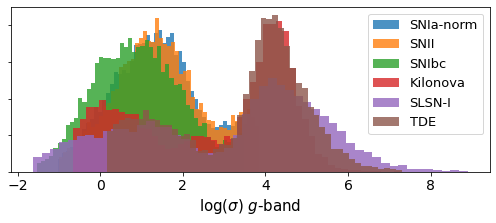

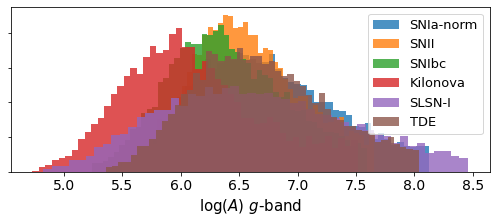

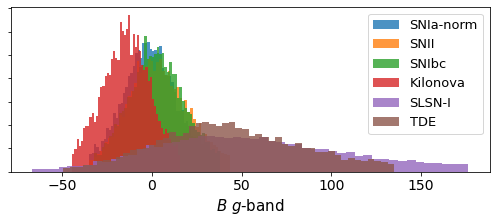

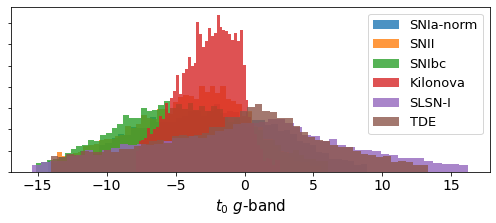

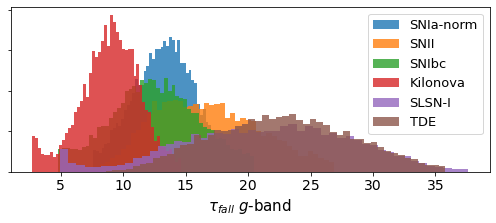

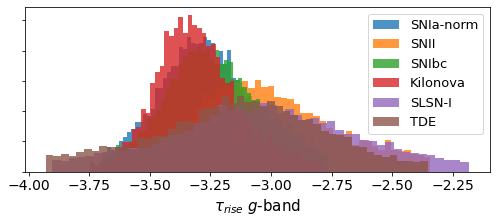

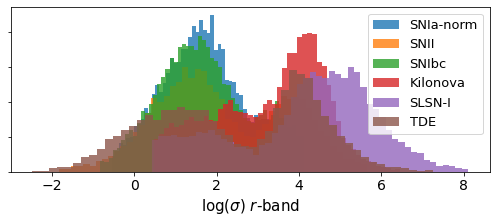

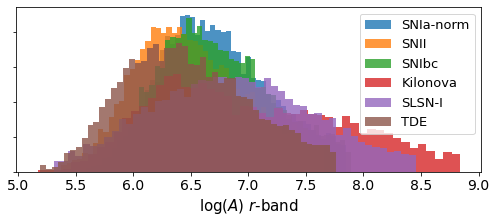

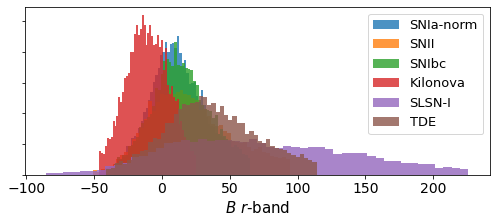

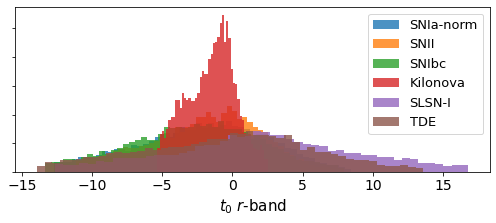

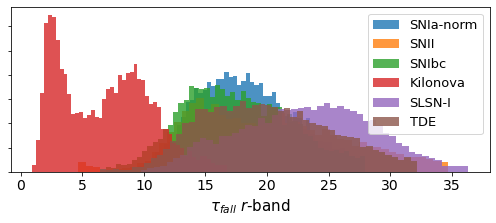

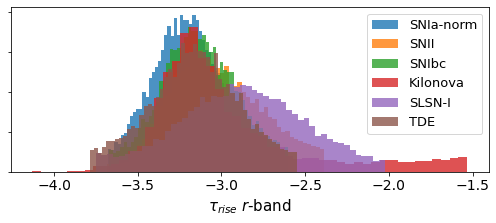

In [ ]:
# Compare different classes bazin paramters as histograms
ndim = 6
passbands = ('g', 'r')

for class_num in [1, 2, 3, 51, 60, 64]:
    with open(f'save_bazin_params_class_multipb_{class_num}_280820_resetpriors_resetx0_allobjects_logs.pickle', 'rb') as f:
        load_bazin_params = pickle.load(f)
    for pb in passbands:
        params_array = np.array(list(load_bazin_params[pb].values()))

        # Using logA and logsigma
        labels = [r"$\log(\sigma)$", r"$\log(A)$", r"$B$", r"$t_0$", r"$\tau_{fall}$", r"$\tau_{rise}$"]
        # params_array[:,0] = np.log(params_array[:,0])
        # params_array[:,1] = np.log(params_array[:,1])
        # labels = [r"$\sigma$", r"$A$", r"$B$", "$t_0$", r"$\tau_{fall}$", r"$\tau_{rise}$"]


        # Compute mean and covariance
        params_array_means = np.mean(params_array, axis=0)
        params_array_sigmas = np.std(params_array, axis=0)
        params_covariance = np.cov(params_array.T)
        # print(f"if class_num == {repr(class_num)}:")
        # print(f"    if passband == {repr(pb)}:")
        # print(f"        means = np.{repr(params_array_means)}")
        # print(f"        covariance = np.{repr(params_covariance)}")
        # print(f"        inverse_covariance = np.{repr(lin.inv(params_covariance))}")
        print(f"x0[{repr(class_num)}][{repr(pb)}] = np.{repr(np.median(params_array, axis=0))}")

        # Plot histograms and remove 3 median absolute deviation outliers for plotting
        params_removed_outliers = []
        for i in range(ndim):
            d = abs(params_array[:,i] - np.median(params_array[:,i]))
            mad = np.median(d)
            params_removed_outliers.append(params_array[:,i][d < 3*mad])
        # print(params_array_means, params_array_sigmas)
        for i in range(ndim):
            fig = plt.figure(f"{i}_{pb}", figsize=(7,3.2))
            ax1 = plt.gca()
            ax1.hist(params_removed_outliers[i], bins=50, density=True, label=f"{helpers.get_sntypes()[class_num]}", alpha=0.9)
            ax1.set_xlabel(fr"{labels[i]} ${pb}$-band", fontsize=15)
            ax1.legend(fontsize=13)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            ax1.axes.yaxis.set_ticklabels([])
            if labels[i] == r"$B$":
                plt.xlim(-5, 5)    
                plt.ylim(0,4)        
            if labels[i] == r"$t_0$":
                plt.xlim(-5, 5)
                plt.ylim(0,1.5)
            if labels[i] == r"$\tau_{fall}$":
                plt.xlim(-5, 40)
            if labels[i] == r"$\tau_{rise}$":
                plt.xlim(-7, 0)
                plt.ylim(0,2)
            plt.tight_layout()
            plt.savefig(f"{i}_{pb}")

In [ ]:
#@title MCMC bazin fit to plasticc data
# ! pip install emcee
# ! pip install corner

import emcee
import corner

labels = ["sigma", "A", "B", "t0", "taufall", "taurise"]
pb = 'g'

save_bazin_params = {}
for objidx, (objid, lc) in enumerate(light_curves.items()):
    if objidx>3: break
    print(objidx, objid)
    try:
        pbmask = lc['passband'] == pb
        time = lc[pbmask]['time'].data
        flux = lc[pmask]['flux'].data
        fluxerr = lc[pbmask]['fluxErr'].data
        photflag = lc[pbmask]['photflag'].data

        # Mask out times outside of mintime and maxtime
        timemask = (time > -70) & (time < 80)
        time = time[timemask]
        flux = flux[timemask]
        fluxerr = fluxerr[timemask]
        photflag = photflag[timemask]

        def objective_func(theta):
            sigma_intrinsic = theta[0]
            if sigma_intrinsic < 0:
                return -np.inf
            return log_posterior(time, flux, fluxerr, fit_until, sigma_intrinsic=theta[0], A=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np)


        pos = res.x + 1e-4 * np.random.randn(100, len(res.x))
        nwalkers, ndim = pos.shape
        print(nwalkers, ndim)

        sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_func)
        sampler.run_mcmc(pos, 2000, progress=True);
        samples = sampler.get_chain(discard=200, flat=True)

        # fig = corner.corner(samples, labels=labels, truths=res.x);

        # print mcmc 16th, 50th and 84th percentiles
        print("\nMCMC 16th, 50th, and 84th percentiles")
        badfit = False
        param_vals = []
        for i in range(ndim):
            mcmc = np.percentile(samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = f"{labels[i]} = {mcmc[1]:.2f} (+{q[0]:.2f}) (-{q[1]:.2f})"
            print(txt)
            param_vals.append(mcmc[1])
            if q[0] > 1e5 or q[1] > 1e5:
                print("Bad fit for", objid, i, q[0], q[1])
                badfit = True
                break
        if badfit:
            continue

        # Save best values
        save_bazin_params[objid] = param_vals

        # Plot draws
        plt.figure()
        t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
        # plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
        plt.errorbar(time, flux, yerr=fluxerr, label='true - used for fitting', fmt='.')
        plt.plot(t_plot, y_pred_plot, label='pred')
        plt.axvspan(t_all[np.argmax(t_data)+1], max(t_all), alpha=0.2, color='grey')
        save_y_pred_draws = []
        for i in range(100):
            sample_idx = np.random.randint(low=0, high=samples.shape[0])
            t_draw, y_pred_draw = get_y_pred(80, *samples[sample_idx][1:])
            plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
            save_y_pred_draws.append(y_pred_draw)
        plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
        plt.legend()
        plt.xlabel('Time in days')
        plt.ylabel('Flux')
        plt.title(f"{objidx}  {objid}")
        plt.show()
        # plt.ylim(bottom=-10, top=70)

    except Exception as e:
        print(i, objid, e)
        continue

# import pickle
# with open('save_bazin_params.pickle', 'wb') as f:
#     pickle.dump(save_bazin_params, f)





[[ 1.67688598e+00  7.00193077e-01  8.82353489e+00  4.48695226e+00
   1.34176611e+00  9.54228266e-02]
 [ 7.00193077e-01  5.18863319e-01  5.49978380e+00  1.93237147e+00
   6.79978370e-01  6.69419004e-02]
 [ 8.82353489e+00  5.49978380e+00  9.87234313e+02  1.99810737e+01
   1.02740660e+01  3.95703621e+00]
 [ 4.48695226e+00  1.93237147e+00  1.99810737e+01  2.73745511e+01
   2.26234792e+00 -5.02746297e-02]
 [ 1.34176611e+00  6.79978370e-01  1.02740660e+01  2.26234792e+00
   1.44470075e+01  5.25918018e-01]
 [ 9.54228266e-02  6.69419004e-02  3.95703621e+00 -5.02746297e-02
   5.25918018e-01  7.75918070e-02]]
[[ 1.62035102e+00  3.95858098e-01  4.55181800e+01  1.64692498e+00
   8.08509351e-01  2.55326872e-01]
 [ 3.95858098e-01  3.34968922e-01  1.42534989e+01  1.42010444e+00
  -1.21029900e-02  1.40085107e-01]
 [ 4.55181800e+01  1.42534989e+01  6.90890382e+03 -2.03177443e+00
   7.78310079e+01  2.54188001e+01]
 [ 1.64692498e+00  1.42010444e+00 -2.03177443e+00  3.18961712e+01
  -9.37891960e+00 -8.277

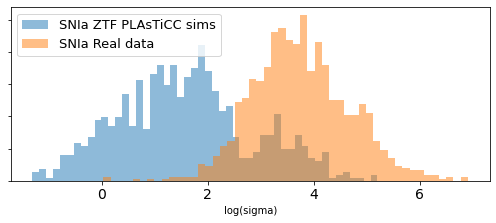

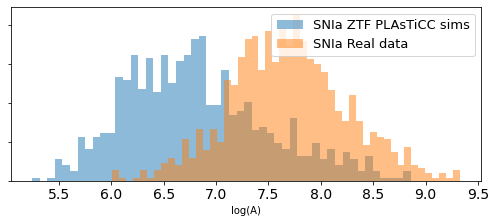

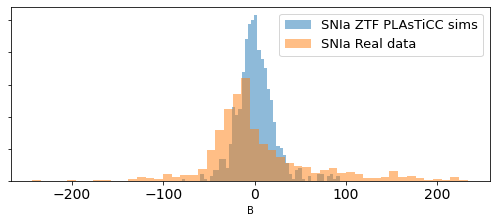

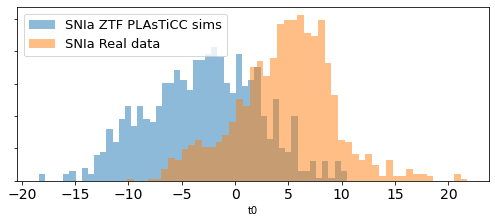

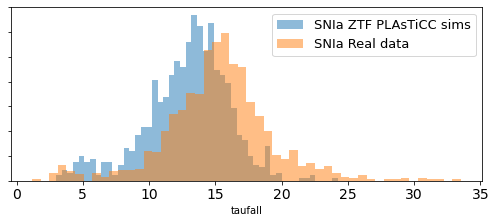

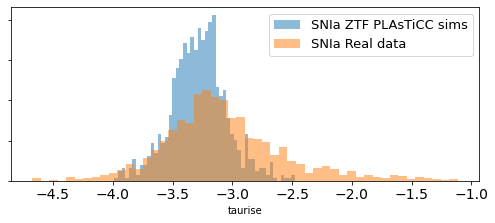

In [ ]:
# Compare real data to simulated data for SNIa

ndim = 6

with open('save_bazin_params.pickle', 'rb') as f:
    load_bazin_params = pickle.load(f)
params_array = np.array(list(load_bazin_params.values()))
#
with open('save_real_data_from_osc_bazin_params.pickle', 'rb') as f:
    load_bazin_params2 = pickle.load(f)
params_array2 = np.array(list(load_bazin_params2.values()))

# Change to logA and logsigma
labels = ["log(sigma)", "log(A)", "B", "t0", "taufall", "taurise"]
params_array[:,0] = np.log(params_array[:,0])
params_array[:,1] = np.log(params_array[:,1])
#
params_array2[:,0] = np.log(params_array2[:,0])
params_array2[:,1] = np.log(params_array2[:,1])

# Compute mean and covariance
params_array_means = np.mean(params_array, axis=0)
params_array_sigmas = np.std(params_array, axis=0)
params_covariance = np.cov(params_array.T)
print(params_covariance)
#
params_array_means2 = np.mean(params_array2, axis=0)
params_array_sigmas2 = np.std(params_array2, axis=0)
params_covariance2 = np.cov(params_array2.T)
print(params_covariance2)

# Plot histograms and remove 3 sigma outliers for plotting
params_removed_outliers = []
for i in range(ndim):
    params_removed_outliers.append(params_array[:,i][abs(params_array[:,i] - np.median(params_array[:,i])) < 3*np.std(params_array[:,i])])
#
params_removed_outliers2 = []
for i in range(ndim):
    params_removed_outliers2.append(params_array2[:,i][abs(params_array2[:,i] - np.median(params_array2[:,i])) < 3*np.std(params_array2[:,i])])
    
print(params_array_means, params_array_sigmas)
for i in range(ndim):
    plt.figure(figsize=(7,3.2))
    plt.hist(params_removed_outliers[i], bins=50, density=True, label="SNIa ZTF PLAsTiCC sims", alpha=0.5)
    plt.hist(params_removed_outliers2[i], bins=50, density=True, label='SNIa Real data', alpha=0.5)
    plt.xlabel(labels[i])
    ax1 = plt.gca()
    ax1.legend(fontsize=13)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax1.axes.yaxis.set_ticklabels([])
    plt.tight_layout()
    plt.savefig(f"real_vs_sims_{i}_{pb}")

In [ ]:
# # np.where(~np.isfinite(params_array))
# params_covariance
# params_array_means
params_array

In [ ]:
params_covariance
np.linalg.inv(params_covariance)
# params_array_means
# np.median(fluxerr)

In [ ]:
#@title Check univariate vs multivariate gaussian priors

# x = np.array([sigma_intrinsic, A, B, t0, tau_fall, tau_rise])
# means = np.array([24.9723914 , 890.8069568 , -26.34104599,  -3.4609063 ,
#                   16.20697774,  -3.40826335])
# covariance = np.array([[ 1.74474637e+02,  2.18543822e+03, -2.70052169e+02,
#                           7.41085359e+00,  1.41350541e+01, -1.71021825e+00],
#                         [ 2.18543822e+03,  2.88251062e+05, -9.25276312e+04,
#                           6.59647012e+02,  2.79607128e+03, -3.53338108e+02],
#                         [-2.70052169e+02, -9.25276312e+04,  6.81433971e+04,
#                           5.16278048e+02, -2.50140730e+03,  2.49325353e+02],
#                         [ 7.41085359e+00,  6.59647012e+02,  5.16278048e+02,
#                           4.14864470e+01, -3.13248842e+01,  1.02721038e+00],
#                         [ 1.41350541e+01,  2.79607128e+03, -2.50140730e+03,
#                           -3.13248842e+01,  1.17189022e+02, -9.34560249e+00],
#                         [-1.71021825e+00, -3.53338108e+02,  2.49325353e+02,
#                           1.02721038e+00, -9.34560249e+00,  1.72261655e+00]])
# n = len(means)
# inverse_covariance = np.array([[6.78744316e-03, -9.29642223e-05, -2.28506150e-04,
#                                     8.05930286e-04, -2.90254365e-03,  4.51563295e-03],
#                                   [-9.29642223e-05,  1.01991443e-05,  2.03397428e-05,
#                                     -3.17739063e-04,  1.00292910e-04, -2.10594624e-04],
#                                   [-2.28506150e-04,  2.03397428e-05,  1.24103770e-04,
#                                     -4.10170214e-04,  1.73313886e-03, -4.36989143e-03],
#                                   [ 8.05930286e-04, -3.17739063e-04, -4.10170214e-04,
#                                     4.35185650e-02,  1.39113687e-02,  4.45149742e-02],
#                                   [-2.90254365e-03,  1.00292910e-04,  1.73313886e-03,
#                                     1.39113687e-02,  4.92597661e-02,  2.57922494e-02],
#                                   [ 4.51563295e-03, -2.10594624e-04, -4.36989143e-03,
#                                     4.45149742e-02,  2.57922494e-02,  1.28766568e+00]])
# log_prior = -(n/2)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covariance)) - 0.5 * (x-means) @ inverse_covariance @ (x-means)
# print(log_prior)

# sigma_intrinsic, A, B, t0, tau_fall, tau_rise = x
# # sigma_intrinsic prior
# sigma_intrinsic_mean = means[0]
# sigma_intrinsic_sigma = np.sqrt(np.diagonal(covariance)[0])
# sigma_log_prior = -0.5*np.log(2*np.pi*sigma_intrinsic_sigma**2)-0.5*(sigma_intrinsic-sigma_intrinsic_mean)**2/sigma_intrinsic_sigma**2

# # A prior
# A_mean = means[1]
# A_sigma = np.sqrt(np.diagonal(covariance)[1])
# A_log_prior = -0.5*np.log(2*np.pi*A_sigma**2)-0.5*(A-A_mean)**2/A_sigma**2

# # B prior
# B_mean = means[2]
# B_sigma = np.sqrt(np.diagonal(covariance)[2])
# B_log_prior = -0.5*np.log(2*np.pi*B_sigma**2)-0.5*(B-B_mean)**2/B_sigma**2

# # t0 prior
# t0_mean = means[3]
# t0_sigma = np.sqrt(np.diagonal(covariance)[3])
# t0_log_prior = -0.5*np.log(2*np.pi*t0_sigma**2)-0.5*(t0-t0_mean)**2/t0_sigma**2

# # tau_fall prior
# tau_fall_mean = means[4]
# tau_fall_sigma = np.sqrt(np.diagonal(covariance)[4])
# tau_fall_log_prior = -0.5*np.log(2*np.pi*tau_fall_sigma**2)-0.5*(tau_fall-tau_fall_mean)**2/tau_fall_sigma**2

# # tau_rise prior
# tau_rise_mean = means[5]
# tau_rise_sigma = np.sqrt(np.diagonal(covariance)[5])
# tau_rise_log_prior = -0.5*np.log(2*np.pi*tau_rise_sigma**2)-0.5*(tau_rise-tau_rise_mean)**2/tau_rise_sigma**2

# log_prior = np.log(1) + sigma_log_prior + A_log_prior + B_log_prior + tau_fall_log_prior + tau_rise_log_prior
# print(log_prior)



4 6.462639541553349 -29.266289715562593 -2.8801525721670704 16.738120320287734 -3.470076377966222
Compute Inverse Hessian using Autograd
[[nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]]
[nan nan nan nan nan nan]


log(sigma)    : true=4,   pred=-1.26 +- nan
log(A)        : true=6.462639541553349, pred=11.81 +- nan
B             : true=-29.266289715562593,   pred=16.28 +- nan
t0            : true=-2.8801525721670704,  pred=2.14 +- nan
tau_fall      : true=16.738120320287734,  pred=0.10 +- nan
tau_rise      : true=-3.470076377966222,  pred=-0.08 +- nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/usr/loc

ValueError: ignored

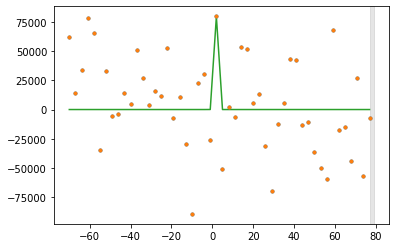

In [ ]:
np.random.seed(42)

# Make dataset
t_all = np.arange(-70,80,step=3)
# sigma_intrinsic = np.random.normal(25, 13)  # 5
# A = np.random.normal(891, 536)  # 100
# B = np.random.normal(-26, 260)  # 
# t0 = np.random.normal(-3.5, 6.4)  # 
# tau_fall = np.random.normal(16.2, 10.8)  # 20
# tau_rise = np.random.normal(-3.4, 1.3)  # -6
# print(sigma_intrinsic, A, B, t0, tau_fall, tau_rise)
data_means = np.array([ 6.20522369,  6.83039727,  3.60728806, -2.72013241, 13.69171025, -3.21985621])
data_covariance = np.array([[7.49096627e+00, 9.01726007e-01, 2.66965110e+01, 8.27519610e+00,
                          3.22998697e+00, 3.02413974e-01],
                        [9.01726007e-01, 5.39866858e-01, 7.91625228e+00, 2.27039763e+00,
                          6.59346887e-01, 8.90609190e-02],
                        [2.66965110e+01, 7.91625228e+00, 4.34861842e+03, 1.73073597e+02,
                          1.03490513e+02, 1.94038357e+01],
                        [8.27519610e+00, 2.27039763e+00, 1.73073597e+02, 4.59726855e+01,
                          5.14228861e+00, 4.92809317e-01],
                        [3.22998697e+00, 6.59346887e-01, 1.03490513e+02, 5.14228861e+00,
                          2.96042102e+01, 1.33934350e+00],
                        [3.02413974e-01, 8.90609190e-02, 1.94038357e+01, 4.92809317e-01,
                          1.33934350e+00, 2.90804476e-01]])
log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise = np.random.multivariate_normal(data_means, data_covariance)
log_sigma_intrinsic = 4
print(log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise)
fit_until = 79  # 30
t_data, y_data, yerr, t_all, y_data_all, yerr_all = get_y_data(fit_until, np.exp(log_sigma_intrinsic), np.exp(logA), B, t0, tau_fall, tau_rise, seed=0, t_all=t_all)
# t_data, y_data, yerr =  time[pb], flux[pb], fluxerr[pb]
class_num = 1
pb = 'g'

#Initial values
# sigma_intrinsic0 = 10
# A0 = 200
# B0 = 10
# t00 = 15
# tau_fall0 = 18
# tau_rise0 = -7
# x0 = np.array([sigma_intrinsic0, A0, B0, t00, tau_fall0, tau_rise0])
x0 = data_means
autograd_numpy = False

# Optimise
def objective_func(theta):
    if autograd_numpy:
        np1 = autograd.numpy
    else:
        np1 = np

    return -log_posterior(class_num, pb, t_data, y_data, yerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)

res = minimize(objective_func, x0, method='Nelder-Mead', options={'disp': True})

# # Compute hessian in two ways
# print("Get Inverse Hessian from BFGS optimiser")
# hessian_inv = res.hess_inv
# print(hessian_inv)
print("Compute Inverse Hessian using Autograd")
autograd_numpy = True
hessian_ = autograd.hessian(objective_func)
autograd_hessian_inv = lin.inv(hessian_(res.x))
print(autograd_hessian_inv)

# Get Uncertaintites
cov_matrix = autograd_hessian_inv
sigmas = np.sqrt(np.diagonal(cov_matrix))
print(sigmas)


# Print comparisons
print("\n")
print(f"log(sigma)    : true={log_sigma_intrinsic},   pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
print(f"log(A)        : true={logA}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
print(f"B             : true={B},   pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
print(f"t0            : true={t0},  pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
print(f"tau_fall      : true={tau_fall},  pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
print(f"tau_rise      : true={tau_rise},  pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")


# Plot
t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
plt.errorbar(t_data, y_data, yerr=yerr, label='true - used for fitting', fmt='.')
plt.plot(t_plot, y_pred_plot, label='pred')
plt.axvspan(fit_until, max(t_all), alpha=0.2, color='grey')

# Draw random parameter functions
save_y_pred_draws = []
for i in range(100):
    param_draws = np.random.multivariate_normal(res.x, cov_matrix)
    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
    plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
    save_y_pred_draws.append(y_pred_draw)
plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')

plt.legend()
plt.xlabel('Time in days')
plt.ylabel('Flux')
plt.ylim(bottom=min(y_data_all), top=max(y_data_all))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 11/1000 [00:00<00:09, 101.31it/s]

100 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
 11%|█         | 110/1000 [00:01<00:07, 111.76it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
100%|██████████| 1000/1000 [00:08<00:00, 111.80it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp



MCMC 16th, 50th, and 84th percentiles
log(sigma) = 232219436086733.53 (+232219423973113.88) (-3436274093412075.00)
log(A) = -232219436086723.03 (+3436274093412075.00) (-232219423973114.00)
B = 5201.43 (+9034.81) (-8625.55)
t0 = 9672800968.72 (+3494725395213528992841728.00) (-2525963239673928374812672.00)
taufall = -14727375336.24 (+7519142202471576210767872.00) (-26071769605955624504393728.00)
taurise = 8058731375.55 (+11020058835985103637708800.00) (-3282768842720623569403904.00)

MLE with sigmas from inverse Hessian
log(sigma)    : true=4,   pred=-1.26 +- nan
log(A)        : true=6.462639541553349, pred=11.81 +- nan
B             : true=-29.266289715562593,   pred=16.28 +- nan
t0            : true=-2.8801525721670704,  pred=2.14 +- nan
tau_fall      : true=16.738120320287734,  pred=0.10 +- nan
tau_rise      : true=-3.470076377966222,  pred=-0.08 +- nan


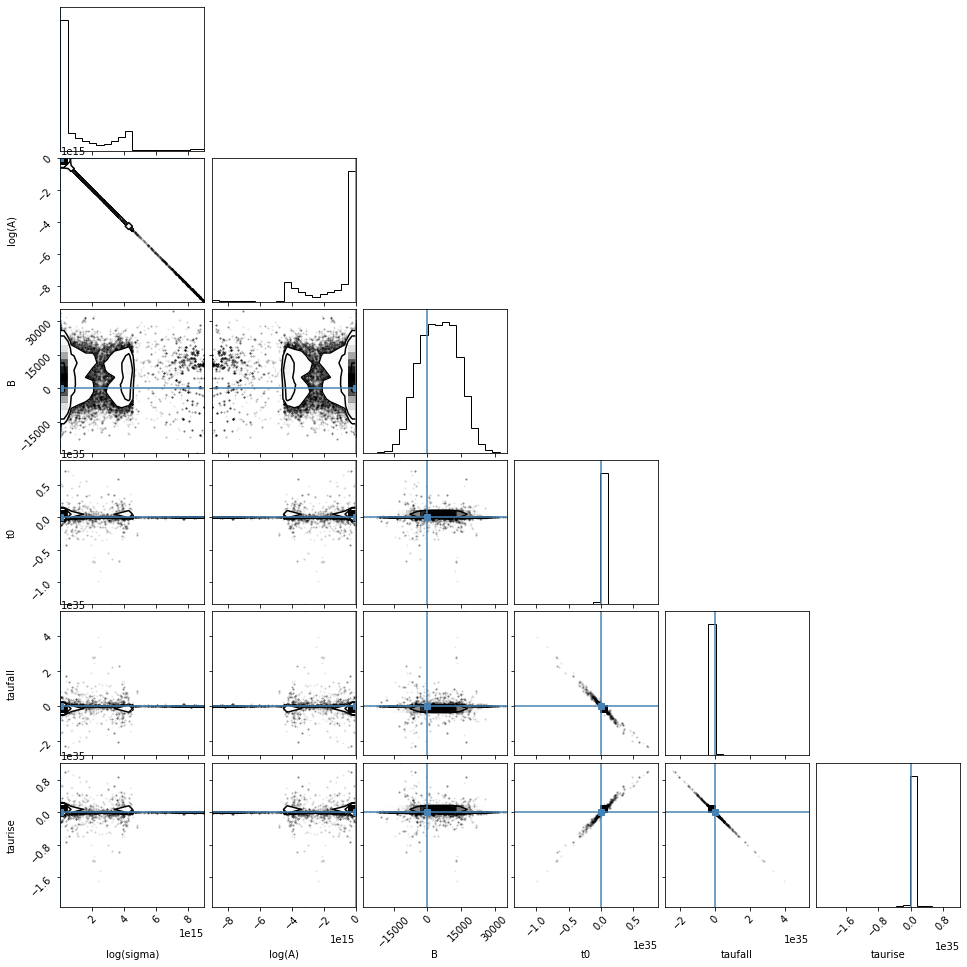

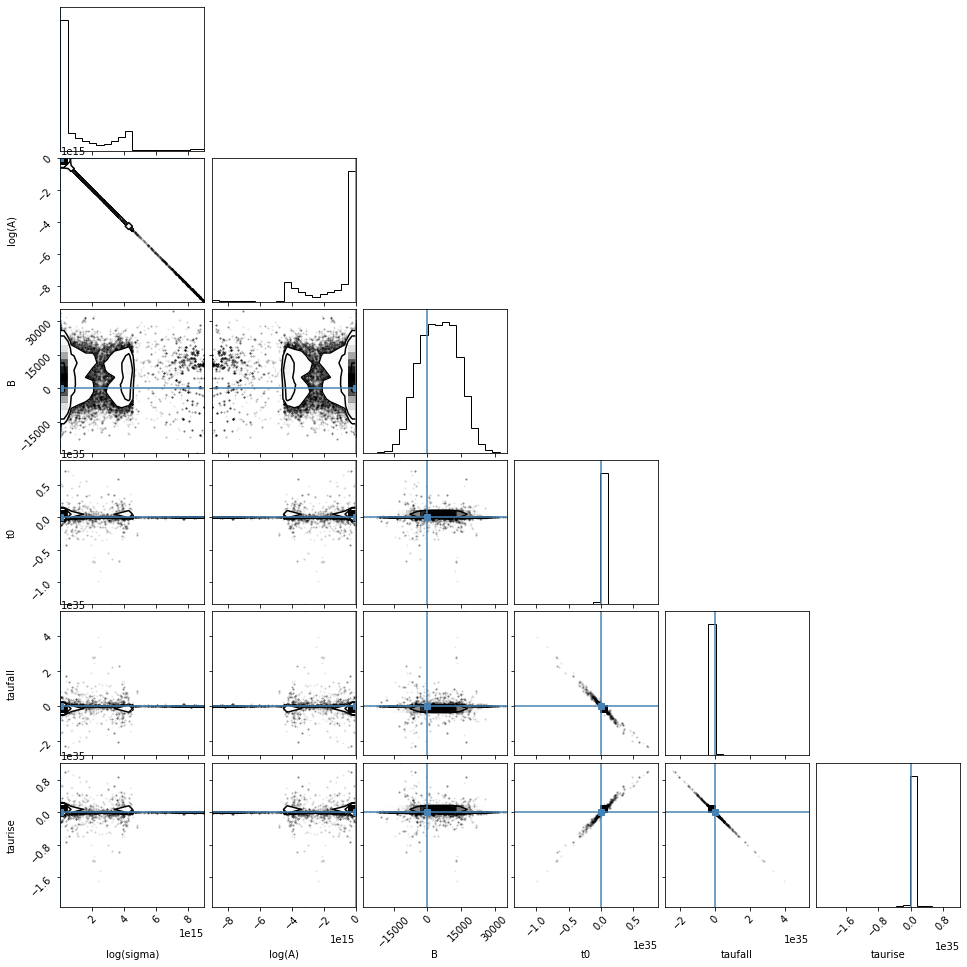

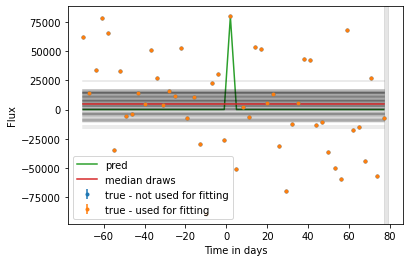

In [ ]:
# ## MCMC fit
# ! pip install emcee
# ! pip install corner
# ! pip install chainconsumer
labels = ["log(sigma)", "log(A)", "B", "t0", "taufall", "taurise"]
def objective_func(theta):
    # return log_posterior(class_num, pb, time, flux, fluxerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np)
    return log_posterior(class_num, pb, t_data, y_data, yerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np)


import emcee
import corner

pos = res.x + 1e-4 * np.random.randn(100, len(res.x))
nwalkers, ndim = pos.shape
print(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_func)
sampler.run_mcmc(pos, 1000, progress=True);
samples = sampler.get_chain(discard=200, flat=True)

fig = corner.corner(samples, labels=labels, truths=[log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise]);

fig = corner.corner(samples, labels=labels, truths=res.x);

# print mcmc 16th, 50th and 84th percentiles
print("\nMCMC 16th, 50th, and 84th percentiles")
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = f"{labels[i]} = {mcmc[1]:.2f} (+{q[0]:.2f}) (-{q[1]:.2f})"
    print(txt)

# Plot draws
plt.figure()
t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
plt.errorbar(t_data, y_data, yerr=yerr, label='true - used for fitting', fmt='.')
# plt.errorbar(time, flux, yerr=fluxerr, label='true - used for fitting', fmt='.')
plt.plot(t_plot, y_pred_plot, label='pred')
plt.axvspan(fit_until, max(t_all), alpha=0.2, color='grey')
save_y_pred_draws = []
for i in range(100):
    sample_idx = np.random.randint(low=0, high=samples.shape[0])
    t_draw, y_pred_draw = get_y_pred(80, *samples[sample_idx][1:])
    plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
    save_y_pred_draws.append(y_pred_draw)
plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
plt.legend()
plt.xlabel('Time in days')
plt.ylabel('Flux')
# plt.ylim(bottom=-10, top=70)

print("\nMLE with sigmas from inverse Hessian")
print(f"log(sigma)    : true={log_sigma_intrinsic},   pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
print(f"log(A)        : true={logA}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
print(f"B             : true={B},   pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
print(f"t0            : true={t0},  pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
print(f"tau_fall      : true={tau_fall},  pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
print(f"tau_rise      : true={tau_rise},  pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")


In [ ]:
#@title Fit Bazin simulations at multiple time steps single passband

for fit_until in range(-70, 80, 3):
    t_data, y_data, yerr, t_all, y_data_all, yerr_all = get_y_data(fit_until, np.exp(log_sigma_intrinsic), np.exp(logA), B, t0, tau_fall, tau_rise, seed=0, t_all=t_all)
    
    def objective_func(theta):
        if autograd_numpy:
            np1 = autograd.numpy
        else:
            np1 = np

        return -log_posterior(t_data, y_data, yerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)

    res = minimize(objective_func, x0, method='BFGS', options={'xatol': 1e-8, 'disp': True})

    # Compute hessian in two ways
    # print("Compute Inverse Hessian using Autograd")
    autograd_numpy = True
    hessian_ = autograd.hessian(objective_func)
    autograd_hessian_inv = lin.inv(hessian_(res.x))
    # print(autograd_hessian_inv)

    # Get Uncertaintites
    cov_matrix = autograd_hessian_inv
    sigmas = np.sqrt(np.diagonal(cov_matrix))
    print(sigmas)
    if np.any(np.isnan(cov_matrix)):
        print("covariance matrix has nans", fit_until, cov_matrix)
        continue

    t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])

    plt.figure()
    plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
    plt.errorbar(t_data, y_data, yerr=yerr, label='true - used for fitting', fmt='.')
    plt.plot(t_plot, y_pred_plot, label='pred')
    plt.axvspan(fit_until, max(t_all), alpha=0.2, color='grey')

    # Draw random parameter functions
    save_y_pred_draws = []
    for i in range(100):
        param_draws = np.random.multivariate_normal(res.x, cov_matrix)
        t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
        plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
        save_y_pred_draws.append(y_pred_draw)
    plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')

    plt.legend()
    plt.xlabel('Time in days')
    plt.ylabel('Flux')
    plt.ylim(bottom=min(y_data_all), top=max(y_data_all))
    plt.show()


    # Print comparisons
    print("\n")
    print(fit_until)
    print(f"log(sigma)    : true={log_sigma_intrinsic},   pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
    print(f"log(A)        : true={logA}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
    print(f"B             : true={B},   pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
    print(f"t0            : true={t0},  pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
    print(f"tau_fall      : true={tau_fall},  pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
    print(f"tau_rise      : true={tau_rise},  pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")



In [ ]:
# Fit actual light curves with Bazin function at different time steps
import warnings
from transomaly import helpers

class_num = 1
passbands = ('g', 'r')
nobjidx = len(light_curves_sims[class_num].items())
x0 = np.array([1.3 , 6 , -26.34104599, -3.4609063, 16.20697774,  -3.40826335])
save_flux_pred = {}
save_fluxerr_pred = {}
save_flux_interp = {}
save_fluxerr_interp = {}

for objidx, (objid, lc) in enumerate(light_curves_sims[class_num].items()):
    if objidx != 13:
        continue
    print(f"{objidx} of {nobjidx}", objid)
    save_flux_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
    save_fluxerr_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
    save_flux_interp[objidx] = {pb: np.zeros(50) for pb in passbands}
    save_fluxerr_interp[objidx] = {pb: np.zeros(50) for pb in passbands}

    for f, fit_until in enumerate(range(-70, 80, 3)):
        print(f"objidx: {objidx}, timestep: {f}")
        plt.close()
        try:
            time, flux, fluxerr, photflag = {}, {}, {}, {}
            t_pred1, y_pred1 = {}, {}
            respb = {}
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time[pb] = lc[pbmask]['time'].data
                flux[pb] = lc[pbmask]['flux'].data
                fluxerr[pb] = lc[pbmask]['fluxErr'].data
                photflag[pb] = lc[pbmask]['photflag'].data

                # Mask out times outside of mintime and maxtime
                timemask = (time[pb] > -70) & (time[pb] < 80)
                time[pb] = time[pb][timemask]
                flux[pb] = flux[pb][timemask]
                fluxerr[pb] = fluxerr[pb][timemask]
                photflag[pb] = photflag[pb][timemask]
                if np.max(flux[pb]) < 1e-5:
                    print(objidx, objid, "Low flux due to incorrect zeropoints")
                    continue

                # Only fit up to day `fit_until`
                mask = (time[pb] <= fit_until) & (time[pb] >= -70)
                time[pb] = time[pb][mask]
                flux[pb] = flux[pb][mask]
                fluxerr[pb] = fluxerr[pb][mask]
                photflag[pb] = photflag[pb][mask]

                # Optimise fit
                autograd_numpy = False
                def objective_func(theta):
                    if autograd_numpy:
                        np1 = autograd.numpy
                    else:
                        np1 = np

                    return -log_posterior(class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)
                res = minimize(objective_func, x0, method='Nelder-Mead', options={'xatol': 1e-12, 'disp': False})
                respb[pb] = res

                # print("Compute Covariance Matrix using Autograd")
                autograd_numpy = True
                hessian_ = autograd.hessian(objective_func)
                autograd_hessian_inv = lin.inv(hessian_(res.x))
                # print(autograd_hessian_inv)
                # Get Uncertaintites
                cov_matrix = autograd_hessian_inv
                sigmas = np.sqrt(np.diagonal(cov_matrix))
                # print(sigmas)

                # Ignore bad fits
                if np.any(np.isnan(cov_matrix)) or np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or res.x[1] <= 0 or np.any(abs(res.x)<1e-4) or np.any(np.isnan(res.x)):
                    print(f"Bad fit for objid {objidx} {objid}. Params: {res.x} sigmas {sigmas}")
                    continue
                

                # Plot draws
                t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
                t_pred1[pb] = t_plot
                y_pred1[pb] = y_pred_plot

                time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
                spl = helpers.ErrorPropagationSpline(time_all, flux_all, fluxerr_all, k=1, N=100, ext='zeros')
                fluxinterp, fluxerrinterp = spl(t_plot)

                if time[pb].size == 0 or fit_until > time_all[-1] or fit_until >= t_plot[-1]:
                    continue
    
                # plt.figure()
                # plt.errorbar(time_all, flux_all, yerr=fluxerr_all, label='true - not used for fitting', fmt='.')
                # plt.errorbar(time[pb], flux[pb], yerr=fluxerr[pb], label='true - used for fitting', fmt='.')
                # plt.plot(t_plot, y_pred_plot, label='pred')
                # # plt.axvspan(time_all[np.argmax(time[pb])+1], max(time_all), alpha=0.2, color='grey')
                # plt.axvspan(fit_until, 80, alpha=0.2, color='grey')
                # save_y_pred_draws = []
                # for i in range(100):
                #     with warnings.catch_warnings():
                #         warnings.simplefilter("ignore")
                #         param_draws = np.random.multivariate_normal(res.x, cov_matrix)
                #     t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                #     save_y_pred_draws.append(y_pred_draw)
                #     # One of these Y-pred_draws has a first prediction of 10**24

                #     plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
                # plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
                # plt.legend()
                # plt.xlabel('Time in days')
                # plt.ylabel(f'Flux {pb} band')
                # plt.title(f"{objidx}  {objid}")
                # plt.ylim(bottom=min(0, min(flux_all), min(y_pred_plot)), top=max(max(flux_all), max(y_pred_plot)))
                # # plt.xlim(left=max(-70, min(time_all)), right = min(80, max(time_all)))
                # plt.xlim(-70, 80)
                # plt.show()

                # # # Print best fit parameters
                # # print("\n")
                # # print(f"log(sigma)    : initial={x0[0]}, pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
                # # print(f"log(A)        : initial={x0[1]}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
                # # print(f"B             : initial={x0[2]}, pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
                # # print(f"t0            : initial={x0[3]}, pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
                # # print(f"tau_fall      : initial={x0[4]}, pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
                # # print(f"tau_rise      : initial={x0[5]}, pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")

                # save_flux_pred[objidx][pb][f+1] = y_pred_plot[f+1]
                # save_fluxerr_pred[objidx][pb][f+1] = np.std(save_y_pred_draws, axis=0)[f+1]
                # save_flux_interp[objidx][pb][f+1] = fluxinterp[f+1]
                # save_fluxerr_interp[objidx][pb][f+1] = fluxerrinterp[f+1]


            # Figures for paper    
            fig, (ax1) = plt.subplots(nrows=1, ncols=1)
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
                ax1.errorbar(time_all, flux_all, yerr=fluxerr_all, label=f'${pb}$ band obs', fmt='.', color=COLPB[pb])
                # ax1.axvspan(fit_until, 80, alpha=0.2, color='grey')
                ax1.axvspan(-67, fit_until, alpha=0.2, color='grey')
                save_y_pred_draws = []
                for i in range(100):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
                    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                    save_y_pred_draws.append(y_pred_draw)
                    ax1.plot(t_draw, y_pred_draw, color=COLPB[pb], alpha=0.05)
                ax1.plot(t_draw, np.median(save_y_pred_draws, axis=0), label=f'${pb}$ band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median
            ax1.set_ylabel("Relative flux", fontsize=15)
            ax1.set_xlabel("Time since trigger [days]", fontsize=15)
            ax1.legend(fontsize=13.5)
            # plt.ylim(bottom=min(0, min(flux_all), min(y_pred_plot)), top=max(max(flux_all), max(y_pred_plot)))
            plt.ylim(-200, 1200)  #
            plt.ylim()
            plt.xlim(-67, 77)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.tight_layout()
            plt.savefig(f"bazin_fit_example_timestep_{f}")
            plt.show()


        except EnvironmentError as e:
            print(objidx, objid, e)
            continue

    # #Compute likelihood and mask out where there is no data
    # for pb in passbands:
    #     mask = (save_fluxerr_pred[objidx][pb] != 0)
    #     yt = save_flux_interp[objidx][pb][mask]
    #     yterr = save_fluxerr_pred[objidx][pb][mask]
    #     yp = save_flux_pred[objidx][pb][mask]
    #     yperr = save_fluxerr_interp[objidx][pb][mask]

    #     negloglike = -0.5 * (yt - yp)**2 / (yterr*2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi)
    #     print(negloglike)
    #     fig = plt.figure()
    #     plt.errorbar(t_plot, save_flux_pred[objidx][pb], yerr=save_fluxerr_pred[objidx][pb], label='pred', fmt='.', linestyle='-')   
    #     plt.errorbar(t_plot, save_flux_interp[objidx][pb], yerr=save_fluxerr_interp[objidx][pb], label='interp data', fmt='.', linestyle='-')
    #     # plt.errorbar(time_all[time_all>=-70], flux_all[time_all>=-70], yerr=fluxerr_all[time_all>=-70], label='data', fmt='.', linestyle='-')
    #     plt.legend()
    #     plt.xlabel('Time in days')
    #     plt.ylabel(f'Flux {pb} band')
    #     plt.title(f"3 day predictions plotted plot {objidx}  {objid}")
    #     plt.ylim(bottom=min(0, min(save_flux_pred[objidx][pb]), min(save_flux_interp[objidx][pb])), top=max(max(save_flux_pred[objidx][pb]), max(save_flux_interp[objidx][pb])))
    #     # plt.xlim(left=max(-70, min(time_all)), right = min(80, max(time_all)))
    #     plt.xlim(-70, 80)
    #     plt.text(0.6, 0.7, f"$negloglike = {round(np.sum(negloglike, axis=0)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
    #     plt.show()

    # # with open('save_real_data_from_osc_bazin_params.pickle', 'wb') as f:
    # # with open(f'save_bazin_params_class_multipb_{class_num}.pickle', 'wb') as f:
    # #     pickle.dump(save_bazin_params, f)


13 of 11962 1_84454778
objidx: 13, timestep: 0


LinAlgError: ignored

In [ ]:
# @title Similarity matrix function definitions
def get_similarity_matrix(class_nums, ignore_class_names_test_on=[]):

    similarity_matrix = {classnum: [] for classnum in class_nums}
    similarity_matrix_chi2 = {classnum: [] for classnum in class_nums}
    for class_num in class_nums:
        sntypes_map = helpers.get_sntypes()
        class_name = sntypes_map[class_num]
        print(class_name)
        saved_scores_fp = f'bazin_similarity_scores_{class_nums}.json'
  
        if os.path.exists(saved_scores_fp):
            print("Using saved similarity scores")
            with open(saved_scores_fp, 'r') as fp:
                similarity_score = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'similarity_scores_chi2_'), 'r') as fp:
                similarity_score_chi2 = json.load(fp)
        else:
            print("Saving similarity scores...")
            similarity_score, similarity_score_chi2 = similarity_metric(class_num, class_nums_to_test_against=class_nums)
            with open(saved_scores_fp, 'w') as fp:
                json.dump(similarity_score, fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'similarity_scores_chi2_'), 'w') as fp:
                json.dump(similarity_score_chi2, fp)

        similarity_matrix[class_name] = similarity_score
        similarity_matrix_chi2[class_name] = similarity_score_std

    similarity_matrix = pd.DataFrame(similarity_matrix)
    similarity_matrix_chi2 = pd.DataFrame(similarity_matrix_chi2)

    similarity_matrix.to_csv('bazin_similarity_matrix.csv')
    similarity_matrix_chi2.to_csv('similarity_matrix_chi2.csv')

    print(similarity_matrix)

    similarity_matrix = similarity_matrix.drop(ignore_class_names_test_on)

    return similarity_matrix


def similarity_metric(class_num, class_nums_to_test_against):
    nobjidx = len(light_curves_sims[class_num].items())
    x0 = np.array([1.3 , 6 , -26.34104599, -3.4609063, 16.20697774,  -3.40826335])
    save_flux_pred = {}
    save_fluxerr_pred = {}
    save_flux_interp = {}
    save_fluxerr_interp = {}
    
    sntypes_map = helpers.get_sntypes()
    class_names = [sntypes_map[class_num] for class_num in class_nums_to_test_against]
    anomaly_scores = {key: [] for key in class_names}
    anomaly_scores_chi2 = {key: [] for key in class_names}
    
    for objidx, (objid, lc) in enumerate(light_curves_sims[class_num].items()):
        
        save_flux_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
        save_fluxerr_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
        save_flux_interp[objidx] = {pb: np.zeros(50) for pb in passbands}
        save_fluxerr_interp[objidx] = {pb: np.zeros(50) for pb in passbands}

        for f, fit_until in enumerate(range(-70, 80, 3)):
            print(f"objidx: {objidx}, {objid} timestep: {f}")
            plt.close()
            time, flux, fluxerr, photflag = {}, {}, {}, {}
            t_pred1, y_pred1 = {}, {}
            respb = {}
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time[pb] = lc[pbmask]['time'].data
                flux[pb] = lc[pbmask]['flux'].data
                fluxerr[pb] = lc[pbmask]['fluxErr'].data
                photflag[pb] = lc[pbmask]['photflag'].data

                # Mask out times outside of mintime and maxtime
                timemask = (time[pb] > -70) & (time[pb] < 80)
                time[pb] = time[pb][timemask]
                flux[pb] = flux[pb][timemask]
                fluxerr[pb] = fluxerr[pb][timemask]
                photflag[pb] = photflag[pb][timemask]
                if np.max(flux[pb]) < 1e-5:
                    print(objidx, objid, "Low flux due to incorrect zeropoints")
                    continue

                # Only fit up to day `fit_until`
                mask = (time[pb] <= fit_until) & (time[pb] >= -70)
                time[pb] = time[pb][mask]
                flux[pb] = flux[pb][mask]
                fluxerr[pb] = fluxerr[pb][mask]
                photflag[pb] = photflag[pb][mask]

                # Optimise fit
                autograd_numpy = False
                def objective_func(theta):
                    if autograd_numpy:
                        np1 = autograd.numpy
                    else:
                        np1 = np

                    return -log_posterior(class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)
                res = minimize(objective_func, x0, method='Nelder-Mead', options={'xatol': 1e-12, 'disp': False})
                respb[pb] = res

                # print("Compute Covariance Matrix using Autograd")
                autograd_numpy = True
                hessian_ = autograd.hessian(objective_func)
                autograd_hessian_inv = lin.inv(hessian_(res.x))
                # print(autograd_hessian_inv)
                # Get Uncertaintites
                cov_matrix = autograd_hessian_inv
                sigmas = np.sqrt(np.diagonal(cov_matrix))
                # print(sigmas)

                # Ignore bad fits
                if np.any(np.isnan(cov_matrix)) or np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or res.x[1] <= 0 or np.any(abs(res.x)<1e-4) or np.any(np.isnan(res.x)):
                    print(f"Bad fit for objid {objidx} {objid}. Params: {res.x} sigmas {sigmas}")
                    continue

                # Get draws
                t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
                t_pred1[pb] = t_plot
                y_pred1[pb] = y_pred_plot
                save_y_pred_draws = []
                for i in range(100):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
                    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                    save_y_pred_draws.append(y_pred_draw)

                time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
                spl = helpers.ErrorPropagationSpline(time_all, flux_all, fluxerr_all, k=1, N=100, ext='zeros')
                fluxinterp, fluxerrinterp = spl(t_plot)

                if time[pb].size == 0 or fit_until > time_all[-1] or fit_until >= t_plot[-1]:
                    continue

                save_flux_pred[objidx][pb][f+1] = y_pred_plot[f+1]
                save_fluxerr_pred[objidx][pb][f+1] = np.std(save_y_pred_draws, axis=0)[f+1]
                save_flux_interp[objidx][pb][f+1] = fluxinterp[f+1]
                save_fluxerr_interp[objidx][pb][f+1] = fluxerrinterp[f+1]

            # # Plot fits at different time steps
            # fig, (ax1) = plt.subplots(nrows=1, ncols=1)
            # for pb in passbands:
            #     pbmask = lc['passband'] == pb
            #     time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
            #     ax1.errorbar(time_all, flux_all, yerr=fluxerr_all, label=f'${pb}$ band obs', fmt='.', color=COLPB[pb])
            #     # ax1.axvspan(fit_until, 80, alpha=0.2, color='grey')
            #     ax1.axvspan(-67, fit_until, alpha=0.2, color='grey')
            #     save_y_pred_draws = []
            #     for i in range(100):
            #         with warnings.catch_warnings():
            #             warnings.simplefilter("ignore")
            #             param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
            #         t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
            #         save_y_pred_draws.append(y_pred_draw)
            #         ax1.plot(t_draw, y_pred_draw, color=COLPB[pb], alpha=0.05)
            #     ax1.plot(t_draw, np.median(save_y_pred_draws, axis=0), label=f'${pb}$ band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median
            # ax1.set_ylabel("Relative flux", fontsize=15)
            # ax1.set_xlabel("Time since trigger [days]", fontsize=15)
            # ax1.legend(fontsize=13.5)
            # plt.ylim(bottom=min(0, min(flux_all), min(y_pred_plot)), top=max(max(flux_all), max(y_pred_plot)))
            # plt.xlim(-67, 77)
            # plt.xticks(fontsize=15)
            # plt.yticks(fontsize=15)
            # plt.tight_layout()
            # plt.show()
        
        # Get anomaly scores
        npb = 0
        chi2 = 0
        like = 0
        negloglike = 0
        maskzeros = True
        for pb in passbands:
            yt = save_flux_interp[objidx][pb]
            yterr = save_fluxerr_pred[objidx][pb]
            yp = save_flux_pred[objidx][pb]
            yperr = save_fluxerr_interp[objidx][pb]
            maskzeros = ((yterr != 0) * (np.isfinite(yterr))) & maskzeros
            try:
                chi2 += ((yp - yt)/yterr)**2
                like += np.exp(-0.5*(yp-yt)**2 / (yterr**2+yperr**2)) * (2*np.pi*(yterr**2+yperr**2))**-0.5
                negloglike += -(-0.5 * (yp - yt)**2 / (yterr*2 + yperr**2))# - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi))
                npb += 1
            except ValueError as e:
                print(f"Failed chi2 object {objids_test[sidx + s]}", e)
            # import pdb; pdb.set_trace()
        if not np.any(maskzeros):
            print("here not any maskzeros")
            continue

        chi2 = chi2[maskzeros] / npb
        like = like[maskzeros] / npb
        negloglike = negloglike[maskzeros] / npb
        
        anomaly_scores_lc = np.array(negloglike)
        anomaly_scores_lc_chi2 = np.array(chi2)

        anomaly_score_max = max(anomaly_scores_lc)
        obj_classnum = int(objid.split('_')[0])
        obj_class_name = sntypes_map[obj_classnum]
        anomaly_scores[obj_class_name].append(anomaly_score_max)

        anomaly_scores_lc_chi2 = np.array(chi2)
        anomaly_score_lc_max = max(anomaly_scores_lc_chi2)
        anomaly_scores_chi2[obj_class_name].append(anomaly_score_lc_max)


        fig = plt.figure()
        plt.errorbar(t_plot, save_flux_pred[objidx][pb], yerr=save_fluxerr_pred[objidx][pb], label='pred', fmt='.', linestyle='-')   
        plt.errorbar(t_plot, save_flux_interp[objidx][pb], yerr=save_fluxerr_interp[objidx][pb], label='interp data', fmt='.', linestyle='-')
        # plt.errorbar(time_all[time_all>=-70], flux_all[time_all>=-70], yerr=fluxerr_all[time_all>=-70], label='data', fmt='.', linestyle='-')
        plt.legend()
        plt.xlabel('Time in days')
        plt.ylabel(f'Flux {pb} band')
        plt.title(f"3 day predictions plotted plot {objidx}  {objid}")
        plt.ylim(bottom=min(0, min(save_flux_pred[objidx][pb]), min(save_flux_interp[objidx][pb])), top=max(max(save_flux_pred[objidx][pb]), max(save_flux_interp[objidx][pb])))
        # plt.xlim(left=max(-70, min(time_all)), right = min(80, max(time_all)))
        plt.xlim(-70, 80)
        plt.text(0.6, 0.7, f"$negloglike = {round(np.sum(negloglike, axis=0)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
        plt.text(0.6, 0.6, f"$chi2 = {round(np.sum(chi2, axis=0)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
        plt.show()

    similarity_score = {key: [] for key in class_names}
    similarity_score_chi2 = {key: [] for key in class_names}
    for c in class_names:
        similarity_score[c] = np.median(anomaly_scores[c])
        similarity_score_chi2[c] = np.median(similarity_score_chi2[c])

    return similarity_score, similarity_score_chi2


def plot_similarity_matrix(similarity_matrix):
    font = {'family': 'normal',
            'size': 36}
    matplotlib.rc('font', **font)

    xrange, yrange = similarity_matrix.shape
    similarity_matrix = similarity_matrix.T
    # similarity_matrix = similarity_matrix[
    #     ['SNIa', 'SNIa-x', 'SNII', 'SNIbc', 'SLSN-I', 'TDE', 'AGN', 'SNIIn', 'Ia-91bg', 'CART', 'TDE', 'PISN',
    #      'Kilonova']]
    xlabels = similarity_matrix.columns.values
    ylabels = similarity_matrix.index.values
    
    sntypes_map = helpers.get_sntypes()
    ylabels = [sntypes_map[ylabel] for ylabel in ylabels]


    maxval = min(20, similarity_matrix.values.max())
    plt.figure(figsize=(15,12))
    plt.imshow(similarity_matrix, cmap=plt.cm.RdBu_r, vmin=6, vmax=maxval)#, norm=colors.LogNorm())

    cb = plt.colorbar()
    # cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=27)
    plt.xticks(np.arange(xrange), xlabels, rotation=90, fontsize=27)
    plt.yticks(np.arange(yrange), ylabels, fontsize=27)

    thresh_q3 = 0.75 * maxval
    thresh_q1 = 0.25 * maxval
    for i in range(xrange):
        for j in range(yrange):
            c = similarity_matrix.iloc[j, i]
            if c > 100:
                cell_text = f"{c:.0f}"
            elif c > 10:
                cell_text = f"{c:.1f}"
            else:
                cell_text = f"{c:.2f}"
            plt.text(i, j, cell_text, va='center', ha='center',
                     color="white" if c < thresh_q1 or c > thresh_q3 else "black", fontsize=14)

    plt.ylabel('Trained on')
    plt.xlabel('Tested on')
    plt.tight_layout()
    print("Saving matrix plot...")
    plt.savefig("bazin_similarity_matrix.pdf")

In [ ]:
# @title # Plot similarity matrix
import warnings
passbands = ('g', 'r')

class_nums = [1, 2, 3, 41, 51, 60, 64]

similarity_matrix, similarity_matrix_chi2 = get_similarity_matrix(class_nums, ignore_class_names_test_on=[])
plot_similarity_matrix(similarity_matrix)

SNIa-norm
Using saved similarity scores


NameError: ignored

In [ ]:
# -0.5 * (yt - yp)**2 / (yterr*2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi)
# print(yt, yp, yterr, yperr)
import transomaly
from transomaly import helpers

In [ ]:
model = build_model(X_train, passbands=('g',), reframe=False, probabilistic=True, nunits=50, bayesian=False, dropout_rate=0.2)

# Load and set weights
with open('save_weights_bazin_mle.pickle', 'rb') as fp:
    load_weights = pickle.load(fp)

model.set_weights(load_weights)

model.compile(loss=negloglike(), optimizer=tf.optimizers.Adam(learning_rate=0.01))
# tcn_full_summary(model, expand_residual_blocks=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=0, batch_size=64, verbose=2)
model.evaluate(X_train, y_train)
# plot_history(history, 'bazinloss')

In [ ]:
yhat = model(X_train)
y_pred = np.asarray(yhat.mean())
y_pred_std = np.asarray(yhat.stddev())
print(y_pred_std.shape)
pidx = 99
time = t[pidx, 1:]
plt.figure()
plt.errorbar(time, y_train[pidx], yerr=sigma, fmt='.', label='true data')
plt.errorbar(time, y_pred[pidx], yerr=y_pred_std[pidx], fmt='x', c='tab:orange', label='one draw from posterior')
plt.legend()


plt.figure()
plt.scatter(time, y_pred_std[pidx], label='predicted sigma one draw')
plt.hlines(y=sigma, xmin=min(time), xmax=max(time), label='true sigma')
# plt.plot(time, sigma, color='k', label='true sigma')
plt.legend()


sampled_ypred = []
sampled_ystd = []
draws = []
ns = 100
for i in range(ns):
    sampled_yhat = model(X_train)
    sampled_ypred.append(np.asarray(sampled_yhat.mean()))
    sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
    draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
mean_sampled_ypred = np.mean(np.array(draws), axis=0)
std_sampled_ypred = np.std(np.array(draws), axis=0)
plt.figure()
plt.errorbar(time, y_train[pidx], yerr=sigma, fmt='.', label='true data')
# for sp in range(ns):
#     plt.errorbar(time, sampled_ypred[sp][pidx], yerr=sampled_ystd[sp][pidx], fmt='.', c='black', alpha=0.01)
plt.errorbar(time, mean_sampled_ypred[pidx], yerr=std_sampled_ypred[pidx], fmt='x', c='tab:orange', alpha=1, label=f'mean of {ns} draws')
plt.legend()


plt.figure()
plt.scatter(time, std_sampled_ypred[pidx], label=f'predicted sigma of {ns} draws')
plt.hlines(y=sigma, xmin=min(time), xmax=max(time), label='true sigma')
# plt.plot(time, sigma[pidx], color='k', label='true sigma')
plt.legend()


In [ ]:
# # Save model weights
# import pickle
# weights = model.get_weights()
# with open('save_weights_bazin_mle.pickle', 'wb') as fp:
#     pickle.dump(weights, fp)

# # Load and set weights
# with open('save_weights_bazin_mle.pickle', 'rb') as fp:
#     load_weights = pickle.load(fp)

# model.set_weights(load_weights)

In [ ]:
print(weights)

In [ ]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglike())
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
print(model.weights)
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
    for npred in range(1, 2):
        SCRIPT_DIR = 'transomaly/'  # os.path.dirname(os.path.abspath(__file__))
        data_dir = os.path.join(SCRIPT_DIR, '..', 'data/ZTF_20190512')
        save_dir = os.path.join(SCRIPT_DIR, '..', 'data/saved_light_curves')
        training_set_dir = os.path.join(SCRIPT_DIR, '..', 'data/training_set_files')
        get_data_func = astrorapid.get_training_data.get_data_from_snana_fits
        fig_dir = os.path.join(SCRIPT_DIR, '..', 'plots')
        passbands = ('g', 'r')
        contextual_info = ()
        known_redshift = True if 'redshift' in contextual_info else False
        nprocesses = None
        class_nums = (1,)
        otherchange = 'single_object_1_50075859'
        nsamples = 1000
        extrapolate_gp = True
        redo = False
        train_epochs = 10000
        retrain = False
        reframe_problem = False
        # npred = 1
        probabilistic = True
        batch_size = 128
        nunits = 30
        train_from_last_stop = 0
        normalise = True
        use_uncertainties = True
        bayesian = True

        # nn_architecture_change = 'norm_onepointpred{}timestepsinfuture_steps{}normalised_{}negloglike_predict_last{}_timesteps_nodropout_100lstmneurons'.format(npred,'probabilistic_' if probabilistic else '', 'reframe_Xy_' if reframe_problem else '', npred)  # 'normalise_mse_withmasking_1000lstmneurons'  # 'chi2'  # 'mse'
        nn_architecture_change = f"NotDenseFlipoutOnly1TCN_{'probabilistic_' if probabilistic else ''}bayesian{bayesian}_uncertainties{use_uncertainties}_predictfuture{npred}point_normalised{normalise}_nodropout_{nunits}units_batchsize{batch_size}"

        fig_dir = os.path.join(fig_dir, "model_{}_ci{}_ns{}_c{}".format(otherchange, contextual_info, nsamples, class_nums))
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func)
        X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
            preparearrays.make_training_set(class_nums, nsamples, otherchange, nprocesses, extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties)

        model, model_name = train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir=fig_dir, epochs=train_epochs,
                            retrain=retrain, passbands=passbands, model_change=nn_architecture_change, reframe=reframe_problem, probabilistic=probabilistic, train_from_last_stop=train_from_last_stop, batch_size=batch_size, nunits=nunits, use_uncertainties=use_uncertainties, bayesian=bayesian)

        plot_metrics(model, model_name, X_test, y_test, timesX_test, yerr_test, labels_test, objids_test, passbands=passbands,
                     fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)
        
        plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
                    fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='_training_set', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)

        # # Test on other classes  #51,60,62,70 AndOtherTypes
        # X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        # timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
        #     preparearrays.make_training_set(class_nums=(1,51,), nsamples=1, otherchange='getKnAndOtherTypes', nprocesses=nprocesses, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties)
        # plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
        #             fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='anomaly', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)


In [ ]:
X_train.shape

In [ ]:
# loss=lambda y, rv_y: -rv_y.log_prob(y)
# model.set_weights(old_weights)
model.compile(loss=negloglike_with_error(), optimizer='adam')
model.evaluate(X_test, y_test)
# Default model

In [ ]:
old_weights = model.get_weights()
with open('save_weights_400epochs_nonbayesian.pickle', 'rb') as fp:
    load_weights = pickle.load(fp)

In [ ]:
print(old_weights[0])
print(load_weights[0])

In [ ]:
yhat = model(X_test)
y_pred = np.asarray(yhat.mean())
y_pred_std = np.asarray(yhat.stddev())
ns = 10
sampled_ypred = []
sampled_ystd = []
for i in range(ns):
    sampled_yhat = model(X_test)
    sampled_ypred.append(np.asarray(sampled_yhat.mean()))
    sampled_ystd.append(np.asarray(sampled_yhat.stddev()))


In [ ]:
np.std(np.array(sampled_ypred), axis=0).shape

In [ ]:
old_weights = model.get_weights()
with open('save_weights_400epochs_nonbayesian.pickle', 'rb') as fp:
    load_weights = pickle.load(fp)

initialise_weights = copy.deepcopy(old_weights)
initialise_weights[0] = load_weights[0]
initialise_weights[2] = load_weights[1]
initialise_weights[3] = load_weights[2]
initialise_weights[5] = load_weights[3]
initialise_weights[6] = load_weights[4]
initialise_weights[8] = load_weights[5]
initialise_weights[9] = load_weights[6]
initialise_weights[11] = load_weights[7]
initialise_weights[12] = load_weights[8]
initialise_weights[14] = load_weights[9]
initialise_weights[15] = load_weights[10]
initialise_weights[17] = load_weights[11]
initialise_weights[18] = load_weights[12]
initialise_weights[20] = load_weights[13]
initialise_weights[21] = load_weights[14]
initialise_weights[23] = load_weights[15]
initialise_weights[24] = load_weights[16]
initialise_weights[26] = load_weights[17]
initialise_weights[27] = load_weights[18]
initialise_weights[28] = load_weights[19]

model.set_weights(old_weights)

In [ ]:
new_weights = model.get_weights()
yhat = model(X_test)
y_pred = np.asarray(yhat.mean())
y_pred_std = np.asarray(yhat.stddev())
np.mean(np.square(y_pred - y_test[:,:,:2]))
#0.09301782987233782


In [ ]:
for i, w in enumerate(load_weights):
    print(i, w.shape)

In [ ]:
for i, w in enumerate(old_weights):
    print(i, w.shape, w)

In [ ]:
plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
            fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='_training_set', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)


In [ ]:
from tensorflow.keras import initializers
initializers.RandomNormal(stddev=0.01)
print(weights)

In [ ]:
# weights_400epochs_nonbayesian = np.array(model.get_weights())
# import pickle
# with open('save_weights_400epochs_nonbayesian.pickle', 'wb') as fp:
#     pickle.dump(weights_400epochs_nonbayesian, fp)

In [ ]:
# weights_400epochs_bayesian = np.array(model.get_weights())
# import pickle
# with open('save_weights_400epochs_bayesian.pickle', 'wb') as fp:
#     pickle.dump(weights_400epochs_bayesian, fp)

In [ ]:

weights = np.array(model.get_weights())
for w in weights:
    print(w.shape)

In [ ]:
for lay in model.layers:
    print(lay.name)
    w = lay.get_weights()
    print(len(w))
    for i in range(len(w)):
      print(w[i].shape)

In [ ]:

tcn_full_summary(model, expand_residual_blocks=True)


In [ ]:
# ! git config --user.email "daniel.muthukrishna@gmail.com"
# ! git config --user.name "daniel-muthukrishna"
# ! git stash
# ! git pull

In [ ]:
# # not-Bayesian:
# Model: "sequential_1"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_1 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1D)     (None, 49, 30)            90        
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            150       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_1 (TimeDist (None, 49, 4)             124       
# _________________________________________________________________
# distribution_lambda_1 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 13,174
# Trainable params: 13,174
# Non-trainable params: 0

# # Bayesian network:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_3 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1DFlipo (None, 49, 30)            150       
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            270       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_3 (TimeDist (None, 49, 4)             244       
# _________________________________________________________________
# distribution_lambda_3 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 26,074
# Trainable params: 26,074
# Non-trainable params: 0

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [ ]:
# Deleted code
    # # sigma_intrinsic prior
    # sigma_intrinsic_mean = 25
    # sigma_intrinsic_sigma = 13
    # sigma_log_prior = -0.5*np.log(2*np.pi*sigma_intrinsic_sigma**2)-0.5*(sigma_intrinsic-sigma_intrinsic_mean)**2/sigma_intrinsic_sigma**2

    # # A prior
    # A_mean = 891
    # A_sigma = 536
    # A_log_prior = -0.5*np.log(2*np.pi*A_sigma**2)-0.5*(A-A_mean)**2/A_sigma**2

    # # B prior
    # B_mean = -26
    # B_sigma = 260
    # B_log_prior = -0.5*np.log(2*np.pi*B_sigma**2)-0.5*(B-B_mean)**2/B_sigma**2

    # # t0 prior
    # t0_mean = -3.5
    # t0_sigma = 6.4
    # t0_log_prior = -0.5*np.log(2*np.pi*t0_sigma**2)-0.5*(t0-t0_mean)**2/t0_sigma**2

    # # tau_fall prior
    # tau_fall_mean = 16.2
    # tau_fall_sigma = 10.8
    # tau_fall_log_prior = -0.5*np.log(2*np.pi*tau_fall_sigma**2)-0.5*(tau_fall-tau_fall_mean)**2/tau_fall_sigma**2

    # # tau_rise prior
    # tau_rise_mean = -3.4
    # tau_rise_sigma = 1.3
    # tau_rise_log_prior = -0.5*np.log(2*np.pi*tau_rise_sigma**2)-0.5*(tau_rise-tau_rise_mean)**2/tau_rise_sigma**2

    # log_prior = np.log(1) + sigma_log_prior + A_log_prior + B_log_prior + tau_fall_log_prior + tau_rise_log_prior